## Lets Start

In [79]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

plt.style.use('seaborn-whitegrid')

In [80]:
!git clone https://github.com/BigcontestParrot2020/csv.git

fatal: destination path 'csv' already exists and is not an empty directory.


In [81]:
!apt install fonts-nanum

import matplotlib as mpl
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fontname = font.get_name()
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


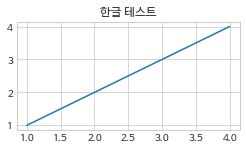

In [82]:
plt.figure(figsize = (4,2))
plt.plot([1,2,3,4],[1,2,3,4])
plt.title('한글 테스트')
plt.show()

In [83]:
!pip install catboost
from catboost import CatBoostRegressor, Pool

In [84]:
!pip install shap
import shap

## Get Data


In [283]:
data = pd.read_csv('/content/csv/0924_ver.csv', encoding = 'utf-8', index_col=1).iloc[:,1:]
del data['소비층']

data['분'] = pd.to_datetime(data.index).strftime('%M')

# [CATBOOST] cateogorical features should be str
data['시'] = data['시'].astype(str)
data['프라임'] = data['프라임'].astype(str)
data['일'] = data['일'].astype(str)
data['휴일'] = data['휴일'].astype(str)

data['취급액_로그'] = np.log(data.취급액)
data = data.drop(columns = ['취급액'])

## Define Functions

In [284]:
def replace(df, replace_list):
    _df = df.copy()
    for l in replace_list:
        _df.상품명 = _df.상품명.str.replace(l, '', regex = False)
    _df.상품명 = _df.상품명.str.replace(' +', ' ')
    _df.상품명 = _df.상품명.str.lstrip()
    _df.상품명 = _df.상품명.str.rstrip()
    return _df

def separate(df, separate_list):
    _df = df.copy()
    for s in separate_list:
        _df.상품명 = _df.상품명.str.replace(s, f' {s} ', regex = False)
    _df.상품명 = _df.상품명.str.replace(' +', ' ')
    _df.상품명 = _df.상품명.str.lstrip()
    _df.상품명 = _df.상품명.str.rstrip()
    return _df

In [285]:
def goods_name(x, goods_list):
    for s in x.split():
        if s in goods_list:
            return s

In [286]:
def preprocessing(data):
    data.상품명 = data.상품명.str.replace(r'\d+[월]', '',)
    data.상품명 = data.상품명.str.replace(r'\d+[차]', '',)
    data.상품명 = data.상품명.str.replace(r'[시][즌]\d+', '',)
    data.상품명 = data.상품명.str.replace(r'[시][즌] \d+', '',)

    data.상품명 = data.상품명.str.replace(r'\d+[.]\d+[k][g]', '',)
    data.상품명 = data.상품명.str.replace(r'\d+[k][g]', '',)
    data.상품명 = data.상품명.str.replace(r'\d+[.]\d+[g]', '',)
    data.상품명 = data.상품명.str.replace(r'\d+[g]', '',)
    data.상품명 = data.상품명.str.replace(r'\d+[.]\d+[L]', '',)
    data.상품명 = data.상품명.str.replace(r'\d+[L]', '',)
    data.상품명 = data.상품명.str.replace(r'\d+[.]\d+[리][터]', '',)
    data.상품명 = data.상품명.str.replace(r'\d+[리][터]', '',)
    data.상품명 = data.상품명.str.replace(r'\d+[.]\d+[m]', '',)
    data.상품명 = data.상품명.str.replace(r'\d+[m]', '',)

    data.상품명 = data.상품명.str.replace(r'\d+[팩]', '',)
    data.상품명 = data.상품명.str.replace(r'\d+[박][스]', '',)
    data.상품명 = data.상품명.str.replace(r'\d+[미]', '')
    data.상품명 = data.상품명.str.replace(r'\d+[개]', '')
    data.상품명 = data.상품명.str.replace(r'\d+[포]', '')
    data.상품명 = data.상품명.str.replace(r'\d+[마][리]', '')

    data.상품명 = data.상품명.str.replace(r'\d+[종]', '',)

    data = replace(data, ['2018년','2018','18년','18','2019년','2019','19년','19'])

    return data

In [287]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [288]:
def plot_result(test_dict, predict_dict, scores_dict):
    fig,  ax = plt.subplots(2,6, figsize = (15, 5))
    for i in range(12):
        x = i//6
        y = i%6
        try:
            ax[x, y].plot(test_dict[i+1], predict_dict[i+1], linestyle = '', marker = 'o')
            ax[x, y].plot(test_dict[i+1], test_dict[i+1], color = 'r')
            ax[x, y].set_title(f'{i+1}: MAPE {round(scores_dict[i+1],2)}')
        except:
            pass

## Commom Features

### feature_결제유형

In [289]:
data.상품명 = data.상품명.str.replace('세일', '', regex = False)

In [290]:
data.상품명 = data.상품명.str.replace('(무)', '무이자', regex = False)
data.상품명 = data.상품명.str.replace('(일)', '일시불', regex = False)

data.상품명 = data.상품명.str.replace('무)', '무이자', regex = False)
data.상품명 = data.상품명.str.replace('일)', '일시불', regex = False)

data = separate(data, ['무이자', '일시불'])

def payment(x):
    if '일시불' in x:
        return '일시불'
    if '무이자' in x:
        return '무이자'
    else:
        return '해당없음'

data['결제유형'] = data.상품명.map(lambda x: payment(x))

data = replace(data, ['무이자', '일시불'])

### feature_성별

In [291]:
data.상품명 = data.상품명.str.replace('남성용', '남성', regex = False)
data.상품명 = data.상품명.str.replace('여성용', '여성', regex = False)
data.상품명 = data.상품명.str.replace('휘메일', '여성', regex = False)
data.상품명 = data.상품명.str.replace('남아', '아동', regex = False)
data.상품명 = data.상품명.str.replace('여성 아동', '아동', regex = False)
data.상품명 = data.상품명.str.replace('남성 아동', '아동', regex = False)

data = separate(data,['남성','여성','아동'])

def sex(x):
    if '남성' in x:
        return '남성'
    if '여성' in x:
        return '여성'
    if '아동' in x:
        return '아동'

data['성별'] = data.상품명.map(lambda x: sex(x))
data['성별'] = data.성별.map(lambda x: '해당없음' if type(x) != str else x)

In [292]:
# data = preprocessing(data)

In [293]:
data_group = {}
for g in set(data.상품군):
    data_group.update({g: data[data.상품군 == g]})

del data

In [294]:
data_group['주방'].head()

,노출(분),상품명,상품군,판매단가,월,일,시,요일,휴일,프라임,파트,브랜드,분,취급액_로그,결제유형,성별
방송일시,,,,,,,,,,,,,,,,
2019-01-01 12:00:00,20.0,에코라믹 통주물 스톤 냄비세트,주방,60900,1,1,12,Tuesday,2,3,First,에코라믹,00,17.336652,해당없음,해당없음
2019-01-01 12:20:00,20.0,에코라믹 통주물 스톤 냄비세트,주방,60900,1,1,12,Tuesday,2,3,Middle,에코라믹,20,17.894454,해당없음,해당없음
2019-01-01 12:40:00,20.0,에코라믹 통주물 스톤 냄비세트,주방,60900,1,1,12,Tuesday,2,3,Later,에코라믹,40,18.413001,해당없음,해당없음
2019-01-02 10:00:00,20.0,쿠첸 풀스텐 압력밥솥 10인용 (A1),주방,158000,1,2,10,Wednesday,0,2,First,쿠첸,00,15.794994,일시불,해당없음
2019-01-02 10:00:00,20.0,쿠첸 풀스텐 압력밥솥 10인용(A1),주방,168000,1,2,10,Wednesday,0,2,First,쿠첸,00,16.007276,무이자,해당없음


In [295]:
model = CatBoostRegressor(iterations = 2000,
                          loss_function="MAPE",
                          eval_metric="MAPE",
                          learning_rate=0.1,
                          early_stopping_rounds=500,
                          random_seed = 123457,
                          )

## 의류

In [305]:
data = data_group['의류'].copy()

### feature_상품

In [306]:
clothes = ['니트/스웨터','카디건','원피스','티셔츠','블라우스','셔츠','점퍼','재킷','코트','맨투맨',
          '데님','스커트','레깅스','바지','트레이닝복','조끼','정장세트','코디세트']

data.상품명 = data.상품명.str.replace('팬츠', '바지')
data.상품명 = data.상품명.str.replace('데님바지','데님')
data.상품명 = data.상품명.str.replace('데님 바지', '데님')

data.상품명 = data.상품명.str.replace('자켓', '재킷')

data.상품명 = data.상품명.str.replace('패딩코트', '점퍼')
data.상품명 = data.상품명.str.replace('패딩', '점퍼')
data.상품명 = data.상품명.str.replace('벤치코트', '점퍼')
data.상품명 = data.상품명.str.replace('구스다운', '점퍼')
data.상품명 = data.상품명.str.replace('하드쉘', '점퍼')

data.상품명 = data.상품명.str.replace('점퍼 바지', '바지')
data.상품명 = data.상품명.str.replace('점퍼 재킷', '재킷')


data.상품명 = data.상품명.str.replace('트레이닝', '트레이닝복')
data.상품명 = data.상품명.str.replace('트랙수트', '트레이닝복')
data.상품명 = data.상품명.str.replace('액티비티', '트레이닝복')
data.상품명 = data.상품명.str.replace('트랙', '트레이닝복')
data.상품명 = data.상품명.str.replace('네이처 수트', '트레이닝복')

data.상품명 = data.상품명.str.replace('니트', '니트/스웨터')
data.상품명 = data.상품명.str.replace('기모티', '니트/스웨터')
data.상품명 = data.상품명.str.replace('모크넥', '니트/스웨터')
data.상품명 = data.상품명.str.replace('터틀넥', '니트/스웨터')

data.상품명 = data.상품명.str.replace('밍크', '코트')
data.상품명 = data.상품명.str.replace('무스탕', '코트')


data = separate(data, clothes)

data['상품'] = data.상품명.map(lambda x: goods_name(x, clothes))
data['상품'] = data.상품.map(lambda x: '코디세트' if type(x) != str else x)

### feature_Statistics

In [307]:
mean_df = data.groupby(['요일','시']).mean()['취급액_로그'].to_frame()
std_df = data.groupby(['요일','시']).std()['취급액_로그'].to_frame()

def statistics(x):
    mean = mean_df.loc[(x.요일, x.시)].values[0]
    std = std_df.loc[(x.요일, x.시)].values[0]
    x['Mean'] = mean
    x['Std'] = std

    return x

data = data.apply(lambda x: statistics(x), axis =1)

In [308]:
goods_mean_df = data.groupby(['요일','시','성별','상품']).mean()['취급액_로그'].to_frame()
goods_std_df = data.groupby(['요일','시','성별','상품']).std()['취급액_로그'].to_frame()

def goods_statistics(x):
    goods_mean = goods_mean_df.loc[(x.요일, x.시, x.성별, x.상품)].values[0]
    goods_std = goods_std_df.loc[(x.요일, x.시, x.성별, x.상품)].values[0]
    x['goods_Mean'] = goods_mean
    x['goods_Std'] = goods_std

    return x

data = data.apply(lambda x:goods_statistics(x), axis =1)

In [309]:
data.to_csv('group_의류.csv')

### Train CATBoost

In [ ]:
month = list(set(data.월))

raw_x = data.drop(columns=['취급액_로그','상품명'])
raw_y = data[['취급액_로그','월']]

cv_test = {}
cv_predict = {}
cv_scores = {}
cv_models = {}
cv_test_dataset = {}

for m in month:

    # try:

    test_x = raw_x[raw_x.월 == m].drop(columns = ['월'])
    test_y = raw_y[raw_y.월 == m].취급액_로그
    train_x = raw_x.drop(index = test_x.index, columns = ['월'])
    train_y = raw_y.drop(index = test_y.index).취급액_로그

    # test_x = mmscaler.fit_transform(test_x)
    # train_x = mmscaler.fit_transform(train_x)

    train_y = train_y.to_numpy().reshape(-1)
    test_y = test_y.to_numpy().reshape(-1)

    cat_features_train = np.where((train_x.dtypes != np.float)&(train_x.dtypes != np.int))[0]
    cat_features_test = np.where((test_x.dtypes != np.float)&(test_x.dtypes != np.int))[0]
    
    train_dataset = Pool(train_x, label = train_y, cat_features=cat_features_train)
    test_dataset = Pool(test_x, label = test_y, cat_features=cat_features_test)
    CBR = model.fit(train_dataset,  
                    eval_set = test_dataset,
                    use_best_model = True,      
                    verbose_eval = 500,
                    plot = False)
    predict_test = model.predict(test_x)

    test_y = np.exp(test_y)
    predict_test = np.exp(predict_test)

    cv_test.update({m:test_y})
    cv_predict.update({m: predict_test})

    mape = mean_absolute_percentage_error(test_y, predict_test)
    print(f'{m}월 MAPE:', mape)

    cv_scores.update({m:mape})
    cv_models.update({m:model})
    cv_test_dataset.update({m:test_dataset})

    print(' ')

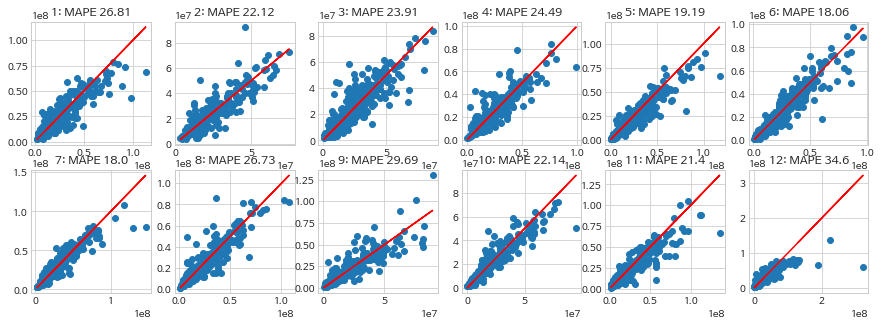

In [103]:
plot_result(cv_test, cv_predict, cv_scores)

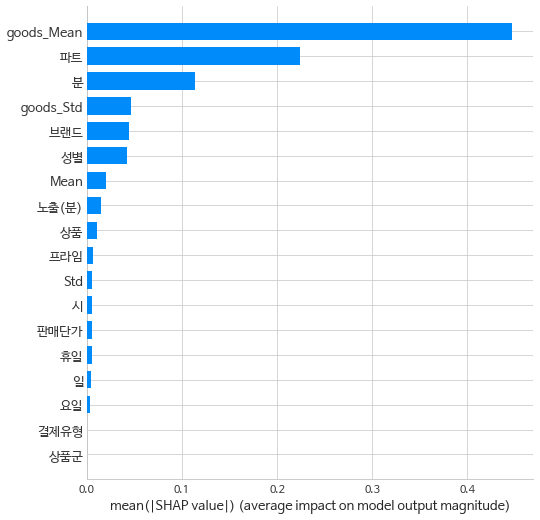

In [104]:
explainer = shap.TreeExplainer(cv_models[6])
shap_values = explainer.shap_values(cv_test_dataset[6])
shap.summary_plot(shap_values, train_x, plot_type="bar")

In [105]:
data_group['의류'] = data

## 속옷

In [311]:
data = data_group['속옷']

### feature_상품

In [312]:
goods_속옷 = ['드로즈','트렁크','브라탑','언더셔츠','브라팬티','동내의',
              '레깅스','보정속옷','베이스레이어', '홈웨어']


data.상품명 = data.상품명.str.replace('란쥬', '보정속옷')
data.상품명 = data.상품명.str.replace('보정', '보정속옷')
data.상품명 = data.상품명.str.replace('코르셋', '보정속옷')
data.상품명 = data.상품명.str.replace('슬리머 패키지', '보정속옷')
data.상품명 = data.상품명.str.replace('쉐이퍼 패키지', '보정속옷')
data.상품명 = data.상품명.str.replace('매직니퍼팬티', '보정속옷')
data.상품명 = data.상품명.str.replace('쉐이핑 거들팬티', '보정속옷')
data.상품명 = data.상품명.str.replace('하이웨이스트', '보정속옷')
data.상품명 = data.상품명.str.replace('하이웨스트', '보정속옷')
data.상품명 = data.상품명.str.replace('코튼 맥시 팬티', '보정속옷') ## 딱히 넣을 데가 없음

data.상품명 = data.상품명.str.replace('레이스 패키지', '브라패키지')
data.상품명 = data.상품명.str.replace('브라 패키지', '브라패키지')
data.상품명 = data.상품명.str.replace('브라패키지', '브라팬티')
data.상품명 = data.상품명.str.replace('브라 컬렉션', '브라팬티')
data.상품명 = data.상품명.str.replace('브라렛 패키지', '브라팬티')
data.상품명 = data.상품명.str.replace('브래팬티', '브라팬티')
data.상품명 = data.상품명.str.replace('브라세트', '브라팬티')
data.상품명 = data.상품명.str.replace('브라세트', '브라팬티')
data.상품명 = data.상품명.str.replace('데오브라', '브라팬티')
data.상품명 = data.상품명.str.replace('오모떼 레이스 파운데이션 브라',
                                      '오모떼 레이스 파운데이션 브라팬티')
data.상품명 = data.상품명.str.replace('리복 스피드윅 에어리라이트 브라 & 숏츠 패키지',
                                      '리복 스피드윅 에어리라이트 브라팬티 & 숏츠 패키지')
data.상품명 = data.상품명.str.replace('베르사유 노와이어 컬렉션 브라',
                                      '베르사유 노와이어 컬렉션 브라팬티')
data.상품명 = data.상품명.str.replace('퀸 컬렉션 프리미엄 브라',
                                      '퀸 컬렉션 프리미엄 브라팬티')



data.상품명 = data.상품명.str.replace('이지웨어', '홈웨어')
data.상품명 = data.상품명.str.replace('이지탑', '홈웨어')
data.상품명 = data.상품명.str.replace('언더탑', '홈웨어')
data.상품명 = data.상품명.str.replace('이너웨어', '홈웨어')
data.상품명 = data.상품명.str.replace('원피스', '홈웨어')
data.상품명 = data.상품명.str.replace('런닝', '홈웨어')

data.상품명 = data.상품명.str.replace('웜웨어', '동내의')

data = separate(data, goods_속옷)

data['상품'] = data.상품명.map(lambda x: goods_name(x, goods_속옷))

### feature_단가

In [313]:
sametime_count = data.groupby(['월','일','시','분','브랜드','성별','결제유형']).count()['상품명'].to_frame()
sametime_df_ = data.groupby(['월','일','시','분','브랜드','성별','결제유형','상품명']).mean()['판매단가'].to_frame()

sametime_df = sametime_df_[sametime_count.상품명 > 1]
sametime_df

Boolean Series key will be reindexed to match DataFrame index.


판매단가
월  일  시  분  브랜드 성별   결제유형 상품명                      
1  11 19 00 카파  해당없음 해당없음 카파 드로즈 패키지 12종      59000
                          카파 홈웨어 패키지 9종       59000
         20 카파  해당없음 해당없음 카파 드로즈 패키지 12종      59000
                          카파 홈웨어 패키지 9종       59000
         40 카파  해당없음 해당없음 카파 드로즈 패키지 12종      59000
...                                             ...
12 9  8  20 푸마  해당없음 해당없음 푸마 웜셀 퍼치마 레깅스 3종    59000
         40 푸마  해당없음 해당없음 푸마 드라이셀 쉐이핑 레깅스 3종  59000
                          푸마 웜셀 퍼치마 레깅스 3종    59000
      9  00 푸마  해당없음 해당없음 푸마 드라이셀 쉐이핑 레깅스 3종  59000
                          푸마 웜셀 퍼치마 레깅스 3종    59000

[1467 rows x 1 columns]

In [314]:
def cheap_expensive(x):
    try: 
        idx_list = sametime_df.loc[(x.월, x.일, x.시, x.분, x.브랜드, x.성별)].values.reshape(-1).tolist()
        idx_list.sort()
        idx = idx_list.index(x.판매단가)/(len(idx_list)-1)
        if idx == 0:
            return '하'
        if idx == 0.5:
            return '중'
        if idx == 1:
            return '상'
    except KeyError:
        return '해당없음'

data['단가'] = data.apply(lambda x: cheap_expensive(x), axis=1)

### feature_Statistics

In [315]:
mean_df = data.groupby(['요일','시']).mean()['취급액_로그'].to_frame()
std_df = data.groupby(['요일','시']).std()['취급액_로그'].to_frame()

def statistics(x):
    mean = mean_df.loc[(x.요일, x.시)].values[0]
    std = std_df.loc[(x.요일, x.시)].values[0]
    x['Mean'] = mean
    x['Std'] = std

    return x

data = data.apply(lambda x: statistics(x), axis =1)

In [316]:
goods_mean_df = data.groupby(['요일','시','성별','상품']).mean()['취급액_로그'].to_frame()
goods_std_df = data.groupby(['요일','시','성별','상품']).std()['취급액_로그'].to_frame()

def goods_statistics(x):
    goods_mean = goods_mean_df.loc[(x.요일, x.시, x.성별, x.상품)].values[0]
    goods_std = goods_std_df.loc[(x.요일, x.시, x.성별, x.상품)].values[0]
    x['goods_Mean'] = goods_mean
    x['goods_Std'] = goods_std

    return x

data = data.apply(lambda x:goods_statistics(x), axis =1)

In [317]:
data.to_csv('group_속옷.csv')

### Train CATBoost

In [112]:
month = list(set(data.월))

raw_x = data.drop(columns=['취급액_로그','상품명'])
raw_y = data[['취급액_로그','월']]

cv_test = {}
cv_predict = {}
cv_scores = {}
cv_models = {}
cv_test_dataset = {}

for m in month:

    # try:

    test_x = raw_x[raw_x.월 == m].drop(columns = ['월'])
    test_y = raw_y[raw_y.월 == m].취급액_로그
    train_x = raw_x.drop(index = test_x.index, columns = ['월'])
    train_y = raw_y.drop(index = test_y.index).취급액_로그

    # test_x = mmscaler.fit_transform(test_x)
    # train_x = mmscaler.fit_transform(train_x)

    train_y = train_y.to_numpy().reshape(-1)
    test_y = test_y.to_numpy().reshape(-1)

    cat_features_train = np.where((train_x.dtypes != np.float)&(train_x.dtypes != np.int))[0]
    cat_features_test = np.where((test_x.dtypes != np.float)&(test_x.dtypes != np.int))[0]
    
    train_dataset = Pool(train_x, label = train_y, cat_features=cat_features_train)
    test_dataset = Pool(test_x, label = test_y, cat_features=cat_features_test)
    CBR = model.fit(train_dataset,  
                    eval_set = test_dataset,
                    use_best_model = True,      
                    verbose_eval = 500,
                    plot = False)
    predict_test = model.predict(test_x)

    test_y = np.exp(test_y)
    predict_test = np.exp(predict_test)

    cv_test.update({m:test_y})
    cv_predict.update({m: predict_test})

    mape = mean_absolute_percentage_error(test_y, predict_test)
    print(f'{m}월 MAPE:', mape)

    cv_scores.update({m:mape})
    cv_models.update({m:model})
    cv_test_dataset.update({m:test_dataset})

0:	learn: 0.0456950	test: 0.0490758	best: 0.0490758 (0)	total: 12.9ms	remaining: 25.8s
500:	learn: 0.0148995	test: 0.0297498	best: 0.0290297 (104)	total: 5.88s	remaining: 17.6s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.02902973439
bestIteration = 104

Shrink model to first 105 iterations.
1월 MAPE: 109.33128040981852
0:	learn: 0.0442611	test: 0.0645876	best: 0.0645876 (0)	total: 12.3ms	remaining: 24.6s
500:	learn: 0.0141517	test: 0.0367301	best: 0.0366800 (331)	total: 5.92s	remaining: 17.7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.03668000158
bestIteration = 331

Shrink model to first 332 iterations.
2월 MAPE: 142.8652202480677
0:	learn: 0.0453316	test: 0.0492673	best: 0.0492673 (0)	total: 14.1ms	remaining: 28.3s
500:	learn: 0.0150068	test: 0.0279042	best: 0.0274735 (110)	total: 6.08s	remaining: 18.2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.02747350864
bestIteration = 110

Shrink model to first 111 iterat

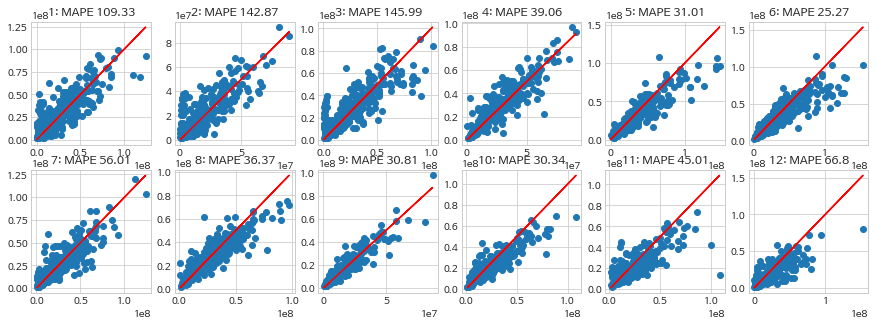

In [113]:
plot_result(cv_test, cv_predict, cv_scores)

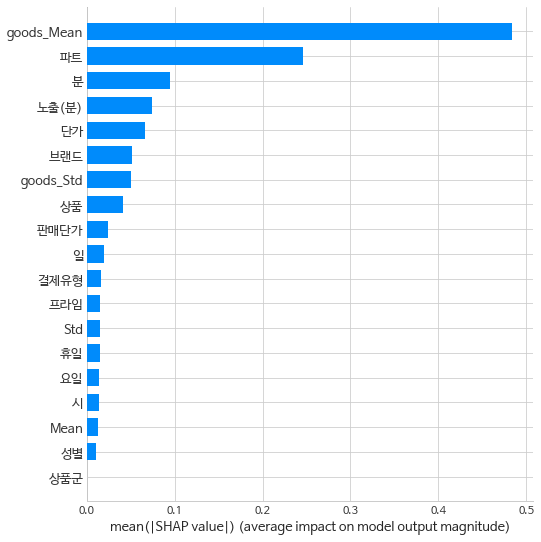

In [114]:
explainer = shap.TreeExplainer(cv_models[6])
shap_values = explainer.shap_values(cv_test_dataset[6])
shap.summary_plot(shap_values, train_x, plot_type="bar")

## 잡화

In [319]:
data = data_group['잡화'].copy()

### Preprocessing & feature_상품

In [320]:
goods_잡화 = ['백팩','크로스백','숄더백','토트백','클러치백','여행가방','가방세트',
              '샌들','스니커즈','단화','운동화','부츠','힐/펌프스','캐쥬얼슈즈',
              '목걸이','팔찌','반지','귀걸이','골드바','목걸이팔찌','팔찌반지','주얼리세트',
              '모자','선글라스','워치','지갑','장갑']

# data.상품명 = data.상품명.str.replace('[+]\w+', '')
# data.상품명 = data.상품명.str.replace('\([^)]*\)', '')

data.상품명 = data.상품명.str.replace('크로스바디백', '크로스백')
data.상품명 = data.상품명.str.replace('크로스바디 백', '크로스백')
data.상품명 = data.상품명.str.replace('크로스 바디백', '크로스백')
data.상품명 = data.상품명.str.replace('클래식 스퀘어 크로스', '크로스백')
data.상품명 = data.상품명.str.replace('크로스 백', '크로스백')
data.상품명 = data.상품명.str.replace('파일백', '크로스백')
data.상품명 = data.상품명.str.replace('투웨이백', '크로스백')

data.상품명 = data.상품명.str.replace('체인숄더', '숄더백')
data.상품명 = data.상품명.str.replace('체인숄더', '숄더백')
data.상품명 = data.상품명.str.replace('체인 숄더', '숄더백')
data.상품명 = data.상품명.str.replace('호보백', '숄더백')
data.상품명 = data.상품명.str.replace('버킷 드로잉 백', '숄더백')
data.상품명 = data.상품명.str.replace('쇼퍼백', '숄더백')
data.상품명 = data.상품명.str.replace('버켓백', '숄더백')
data.상품명 = data.상품명.str.replace('버켓 백', '숄더백')
data.상품명 = data.상품명.str.replace('버킷백', '숄더백')

data.상품명 = data.상품명.str.replace('노벨라백', '토트백')
data.상품명 = data.상품명.str.replace('미란다백', '토트백')
data.상품명 = data.상품명.str.replace('사첼백', '토트백')
data.상품명 = data.상품명.str.replace('사첼', '토트백')
data.상품명 = data.상품명.str.replace('모터백', '토트백')
data.상품명 = data.상품명.str.replace('핸드백', '토트백')
data.상품명 = data.상품명.str.replace('스퀘어백', '토트백')
data.상품명 = data.상품명.str.replace('캐리올', '토트백')
data.상품명 = data.상품명.str.replace('피닉스 보스턴', '토트백')
data.상품명 = data.상품명.str.replace('메디오백', '토트백')

data.상품명 = data.상품명.str.replace('리스틀릿', '클러치백')
data.상품명 = data.상품명.str.replace('웨이스트백', '클러치백')

data.상품명 = data.상품명.str.replace('플라이트백', '백팩')

data.상품명 = data.상품명.str.replace('백 4종', '가방세트')
data.상품명 = data.상품명.str.replace('백 3종세트', '가방세트')
data.상품명 = data.상품명.str.replace('남성 화 3종', '가방세트')

data.상품명 = data.상품명.str.replace('헤라 컬렉션', '주얼리세트')
data.상품명 = data.상품명.str.replace('주얼리', '주얼리세트')

data.상품명 = data.상품명.str.replace('러닝화', '운동화')
data.상품명 = data.상품명.str.replace('워킹화', '운동화')
data.상품명 = data.상품명.str.replace('트레킹화', '운동화')
data.상품명 = data.상품명.str.replace('방한화', '운동화')

data.상품명 = data.상품명.str.replace('로퍼', '단화')
data.상품명 = data.상품명.str.replace('슬립온', '단화')

data.상품명 = data.상품명.str.replace('펌프스', '힐/펌프스')

#data.상품명 = data.상품명.str.replace('', '힐/펌프스')

data = separate(data, goods_잡화)

data.상품명 = data.상품명.str.replace('숄더 ', '숄더백')
data.상품명 = data.상품명.str.replace('목걸이 팔찌', '목걸이팔찌')
data.상품명 = data.상품명.str.replace('팔찌 반지', '팔찌반지')


data['상품'] = data.상품명.map(lambda x: goods_name(x, goods_잡화))
data['상품'] = data.상품.map(lambda x: '패션소품' if type(x) != str else x)

### feature_단가

In [321]:
sametime_count = data.groupby(['월','일','시','분','브랜드','상품']).count()['상품명'].to_frame()
sametime_df_ = data.groupby(['월','일','시','분','브랜드','상품','상품명']).mean()['판매단가'].to_frame()

sametime_df = sametime_df_[sametime_count.상품명 > 1]

Boolean Series key will be reindexed to match DataFrame index.


In [322]:
def cheap_expensive(x):
    try: 
        idx_list = sametime_df.loc[(x.월, x.일, x.시, x.분, x.브랜드, x.상품, x.결제유형)].values.reshape(-1).tolist()
        idx_list.sort()
        idx = idx_list.index(x.판매단가)/(len(idx_list)-1)
        if idx == 0:
            return '하'
        if idx == 0.5:
            return '중'
        if idx == 1:
            return '상'
    except KeyError:
        return '해당없음'

data['단가'] = data.apply(lambda x: cheap_expensive(x), axis=1)

### feature_Statistics

In [323]:
mean_df = data.groupby(['요일','시']).mean()['취급액_로그'].to_frame()
std_df = data.groupby(['요일','시']).std()['취급액_로그'].to_frame()

def statistics(x):
    mean = mean_df.loc[(x.요일, x.시)].values[0]
    std = std_df.loc[(x.요일, x.시)].values[0]
    x['Mean'] = mean
    x['Std'] = std

    return x

data = data.apply(lambda x: statistics(x), axis =1)

In [324]:
goods_mean_df = data.groupby(['요일','시','결제유형','상품']).mean()['취급액_로그'].to_frame()
goods_std_df = data.groupby(['요일','시','결제유형','상품']).std()['취급액_로그'].to_frame()

def goods_statistics(x):
    goods_mean = goods_mean_df.loc[(x.요일, x.시, x.결제유형, x.상품)].values[0]
    goods_std = goods_std_df.loc[(x.요일, x.시, x.결제유형, x.상품)].values[0]
    x['goods_Mean'] = goods_mean
    x['goods_Std'] = goods_std

    return x

data = data.apply(lambda x:goods_statistics(x), axis =1)

In [325]:
data.to_csv('group_잡화.csv')

### Train CATBoost

In [121]:
month = list(set(data.월))

raw_x = data.drop(columns=['취급액_로그','상품명'])
raw_y = data[['취급액_로그','월']]

cv_test = {}
cv_predict = {}
cv_scores = {}
cv_models = {}
cv_test_dataset = {}

for m in month:

    # try:

    test_x = raw_x[raw_x.월 == m].drop(columns = ['월'])
    test_y = raw_y[raw_y.월 == m].취급액_로그
    train_x = raw_x.drop(index = test_x.index, columns = ['월'])
    train_y = raw_y.drop(index = test_y.index).취급액_로그

    # test_x = mmscaler.fit_transform(test_x)
    # train_x = mmscaler.fit_transform(train_x)

    train_y = train_y.to_numpy().reshape(-1)
    test_y = test_y.to_numpy().reshape(-1)

    cat_features_train = np.where((train_x.dtypes != np.float)&(train_x.dtypes != np.int))[0]
    cat_features_test = np.where((test_x.dtypes != np.float)&(test_x.dtypes != np.int))[0]
    
    train_dataset = Pool(train_x, label = train_y, cat_features=cat_features_train)
    test_dataset = Pool(test_x, label = test_y, cat_features=cat_features_test)
    CBR = model.fit(train_dataset,  
                    eval_set = test_dataset,
                    use_best_model = True,      
                    verbose_eval = 500,
                    plot = False)
    predict_test = model.predict(test_x)

    test_y = np.exp(test_y)
    predict_test = np.exp(predict_test)

    cv_test.update({m:test_y})
    cv_predict.update({m: predict_test})

    mape = mean_absolute_percentage_error(test_y, predict_test)
    print(f'{m}월 MAPE:', mape)

    cv_scores.update({m:mape})
    cv_models.update({m:model})
    cv_test_dataset.update({m:test_dataset})

    print(' ')

0:	learn: 0.0436079	test: 0.0418233	best: 0.0418233 (0)	total: 11.8ms	remaining: 23.6s
500:	learn: 0.0136118	test: 0.0175202	best: 0.0168092 (108)	total: 5.76s	remaining: 17.2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.01680919944
bestIteration = 108

Shrink model to first 109 iterations.
1월 MAPE: 23.509597735159673
 
0:	learn: 0.0437515	test: 0.0471933	best: 0.0471933 (0)	total: 11.8ms	remaining: 23.6s
500:	learn: 0.0136428	test: 0.0141660	best: 0.0141516 (494)	total: 5.86s	remaining: 17.5s
1000:	learn: 0.0121770	test: 0.0141200	best: 0.0139895 (921)	total: 11.7s	remaining: 11.7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.01398946851
bestIteration = 921

Shrink model to first 922 iterations.
2월 MAPE: 23.22411452812479
 
0:	learn: 0.0438331	test: 0.0411179	best: 0.0411179 (0)	total: 13.2ms	remaining: 26.3s
500:	learn: 0.0135266	test: 0.0136608	best: 0.0136591 (499)	total: 5.8s	remaining: 17.4s
1000:	learn: 0.0119831	test: 0.0132433	b

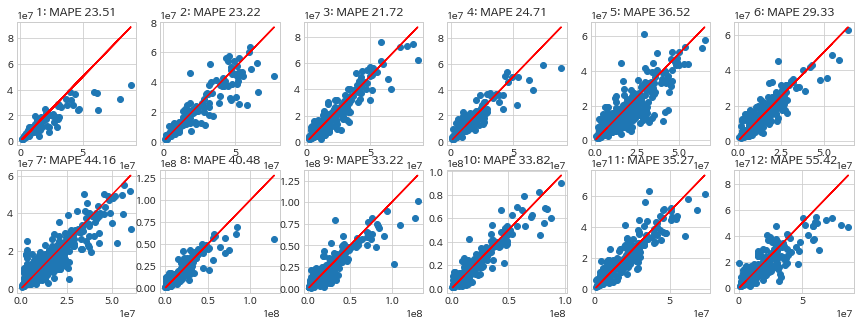

In [122]:
plot_result(cv_test, cv_predict, cv_scores)

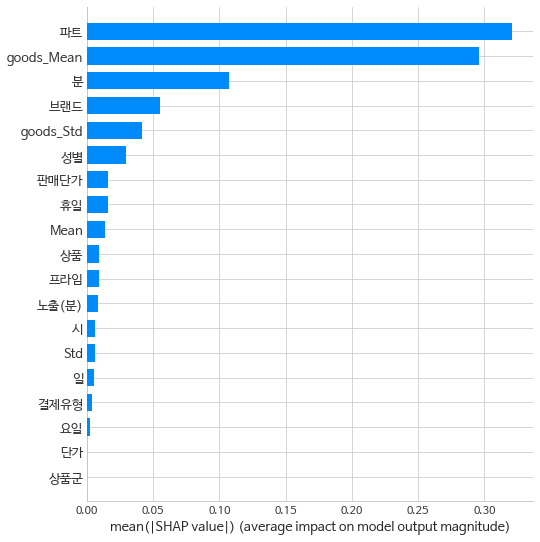

In [123]:
explainer = shap.TreeExplainer(cv_models[6])
shap_values = explainer.shap_values(cv_test_dataset[6])
shap.summary_plot(shap_values, train_x, plot_type="bar",)

In [124]:
data_group['잡화'] = data

## 주방

In [326]:
data = data_group['주방'].copy()

### feature_상품

In [327]:
clothes = ['전기밥솥','가스레인지','에어프라이어','주방가전',
           '믹서기','그릴','식기','잔/컵','냄비/솥',
           '프라이팬','주전자/티포트','보관/밀폐용기','조리기구','하이브리드','주방잡화']

data.상품명 = data.상품명.str.replace('블랜더', '믹서기')
data.상품명 = data.상품명.str.replace('텀블러 믹서기', '믹서기')
data.상품명 = data.상품명.str.replace('믹서를 품은 텀블러', '믹서기')
data.상품명 = data.상품명.str.replace('다지기', '믹서기')
data.상품명 = data.상품명.str.replace('블랜더', '믹서기')
data.상품명 = data.상품명.str.replace('블렌더', '믹서기')
data.상품명 = data.상품명.str.replace('홈밀맷돌', '믹서기')

data.상품명 = data.상품명.str.replace('압력밥솥', '전기밥솥')

data.상품명 = data.상품명.str.replace('용기', '보관/밀폐용기')
data.상품명 = data.상품명.str.replace('후레쉬', '보관/밀폐용기')
data.상품명 = data.상품명.str.replace('유로오븐글라스', '보관/밀폐용기')

data.상품명 = data.상품명.str.replace('홈세트', '식기')
data.상품명 = data.상품명.str.replace('디너세트', '식기')

data.상품명 = data.상품명.str.replace('도마', '조리기구')
data.상품명 = data.상품명.str.replace('참소쿠리', '조리기구')
data.상품명 = data.상품명.str.replace('칼블럭', '조리기구')

data.상품명 = data.상품명.str.replace('텀블러', '잔/컵')
data.상품명 = data.상품명.str.replace('보온병', '잔/컵')

data.상품명 = data.상품명.str.replace('티포트', '주전자/티포트')
data.상품명 = data.상품명.str.replace('티메이커', '주전자/티포트')

data.상품명 = data.상품명.str.replace('냄비', '냄비/솥')
data.상품명 = data.상품명.str.replace('가마솥', '냄비/솥')

data.상품명 = data.상품명.str.replace('후라이팬', '프라이팬')
data.상품명 = data.상품명.str.replace('실버팬', '프라이팬')
data.상품명 = data.상품명.str.replace('양면팬', '프라이팬')

data.상품명 = data.상품명.str.replace('행주', '주방잡화')
data.상품명 = data.상품명.str.replace('수세미', '주방잡화')
data.상품명 = data.상품명.str.replace('지퍼백', '주방잡화')
data.상품명 = data.상품명.str.replace('싱크선반', '주방잡화')


data = separate(data, clothes)

data['상품'] = data.상품명.map(lambda x: goods_name(x, clothes))
data['상품'] = data.상품.map(lambda x: '주방가전' if type(x) != str else x)

### feature_단가

In [328]:
sametime_count = data.groupby(['월','일','시','분','브랜드','상품','결제유형']).count()['상품명'].to_frame()
sametime_df_ = data.groupby(['월','일','시','분','브랜드','상품','결제유형','상품명']).mean()['판매단가'].to_frame()

sametime_df = sametime_df_[sametime_count.상품명 > 1]
sametime_df

Boolean Series key will be reindexed to match DataFrame index.


판매단가
월  일  시  분  브랜드 상품    결제유형 상품명                            
1  10 10 00 린나이 가스레인지 무이자  린나이 간편쿡 자동불꽃조절 가스레인지 2구  218000
                           린나이 간편쿡 자동불꽃조절 가스레인지 3구  238000
                      일시불  린나이 간편쿡 자동불꽃조절 가스레인지 2구  208000
                           린나이 간편쿡 자동불꽃조절 가스레인지 3구  228000
         20 린나이 가스레인지 무이자  린나이 간편쿡 자동불꽃조절 가스레인지 2구  218000
...                                                    ...
12 9  19 40 쿠첸  전기밥솥  일시불  쿠첸 전기밥솥 6인용              148000
      20 00 쿠첸  전기밥솥  무이자  쿠첸 전기밥솥 10인용             178000
                           쿠첸 전기밥솥 6인용              158000
                      일시불  쿠첸 전기밥솥 10인용             168000
                           쿠첸 전기밥솥 6인용              148000

[3699 rows x 1 columns]

In [329]:
def cheap_expensive(x):
    try: 
        idx_list = sametime_df.loc[(x.월, x.일, x.시, x.분, x.브랜드, x.결제유형)].values.reshape(-1).tolist()
        idx_list.sort()
        idx = idx_list.index(x.판매단가)/(len(idx_list)-1)
        if idx == 0:
            return '하'
        if idx == 0.5:
            return '중'
        if idx == 1:
            return '상'
    except KeyError:
        return '해당없음'

data['단가'] = data.apply(lambda x: cheap_expensive(x), axis=1)

### feature_브랜드(추가)

In [330]:
data.브랜드 = data.브랜드.str.replace('센스락무선진공포장기','센스락')
data.브랜드 = data.브랜드.fillna(' ')
brand_list = list(set(data.브랜드.dropna()))
data = separate(data, brand_list)
#data = replace(data, brand_list)

### feature_Statistics

In [332]:
mean_df = data.groupby(['요일','시']).mean()['취급액_로그'].to_frame()
std_df = data.groupby(['요일','시']).std()['취급액_로그'].to_frame()

def statistics(x):
    mean = mean_df.loc[(x.요일, x.시)].values[0]
    std = std_df.loc[(x.요일, x.시)].values[0]
    x['Mean'] = mean
    x['Std'] = std

    return x

data = data.apply(lambda x: statistics(x), axis =1)

In [333]:
goods_mean_df = data.groupby(['요일','시','결제유형','상품']).mean()['취급액_로그'].to_frame()
goods_std_df = data.groupby(['요일','시','결제유형','상품']).std()['취급액_로그'].to_frame()

def goods_statistics(x):
    goods_mean = goods_mean_df.loc[(x.요일, x.시, x.결제유형, x.상품)].values[0]
    goods_std = goods_std_df.loc[(x.요일, x.시, x.결제유형, x.상품)].values[0]
    x['goods_Mean'] = goods_mean
    x['goods_Std'] = goods_std

    return x

data = data.apply(lambda x:goods_statistics(x), axis =1)

In [334]:
data.to_csv('group_주방.csv')

### Train *CATBoost*

In [133]:
month = list(set(data.월))

raw_x = data.drop(columns=['취급액_로그','상품명'])
raw_y = data[['취급액_로그','월']]

cv_test = {}
cv_predict = {}
cv_scores = {}
cv_models = {}
cv_test_dataset = {}

for m in month:

    # try:

    test_x = raw_x[raw_x.월 == m].drop(columns = ['월'])
    test_y = raw_y[raw_y.월 == m].취급액_로그
    train_x = raw_x.drop(index = test_x.index, columns = ['월'])
    train_y = raw_y.drop(index = test_y.index).취급액_로그

    # test_x = mmscaler.fit_transform(test_x)
    # train_x = mmscaler.fit_transform(train_x)

    train_y = train_y.to_numpy().reshape(-1)
    test_y = test_y.to_numpy().reshape(-1)

    cat_features_train = np.where((train_x.dtypes != np.float)&(train_x.dtypes != np.int))[0]
    cat_features_test = np.where((test_x.dtypes != np.float)&(test_x.dtypes != np.int))[0]
    
    train_dataset = Pool(train_x, label = train_y, cat_features=cat_features_train)
    test_dataset = Pool(test_x, label = test_y, cat_features=cat_features_test)
    CBR = model.fit(train_dataset,  
                    eval_set = test_dataset,
                    use_best_model = True,      
                    verbose_eval = 500,
                    plot = False)
    predict_test = model.predict(test_x)

    test_y = np.exp(test_y)
    predict_test = np.exp(predict_test)

    cv_test.update({m:test_y})
    cv_predict.update({m: predict_test})

    mape = mean_absolute_percentage_error(test_y, predict_test)
    print(f'{m}월 MAPE:', mape)

    cv_scores.update({m:mape})
    cv_models.update({m:model})
    cv_test_dataset.update({m:test_dataset})

    print(' ')

0:	learn: 0.0461575	test: 0.0548869	best: 0.0548869 (0)	total: 16.8ms	remaining: 33.6s
500:	learn: 0.0130496	test: 0.0261761	best: 0.0261748 (497)	total: 6.95s	remaining: 20.8s
1000:	learn: 0.0118189	test: 0.0258085	best: 0.0258058 (979)	total: 13.8s	remaining: 13.8s
1500:	learn: 0.0111363	test: 0.0258937	best: 0.0257873 (1090)	total: 20.9s	remaining: 6.95s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.02578727816
bestIteration = 1090

Shrink model to first 1091 iterations.
1월 MAPE: 48.34768311932087
 
0:	learn: 0.0466804	test: 0.0509797	best: 0.0509797 (0)	total: 15.5ms	remaining: 31s
500:	learn: 0.0136101	test: 0.0199314	best: 0.0199185 (476)	total: 7.11s	remaining: 21.3s
1000:	learn: 0.0124029	test: 0.0199920	best: 0.0199061 (719)	total: 14.2s	remaining: 14.2s
1500:	learn: 0.0116529	test: 0.0197117	best: 0.0196986 (1463)	total: 21.2s	remaining: 7.05s
1999:	learn: 0.0111344	test: 0.0195952	best: 0.0195835 (1913)	total: 28.2s	remaining: 0us

bestTest = 0.0195834

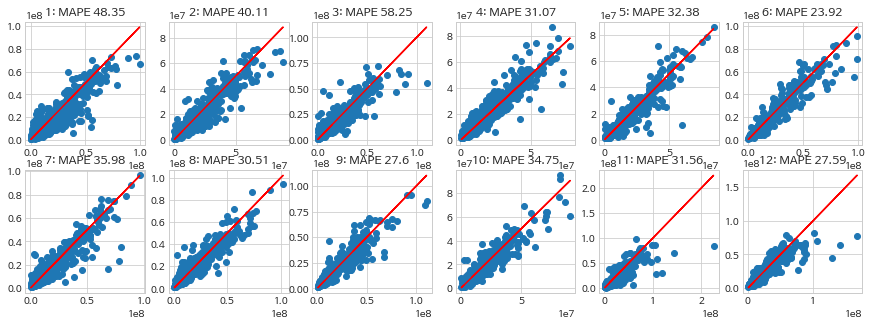

In [134]:
plot_result(cv_test, cv_predict, cv_scores)

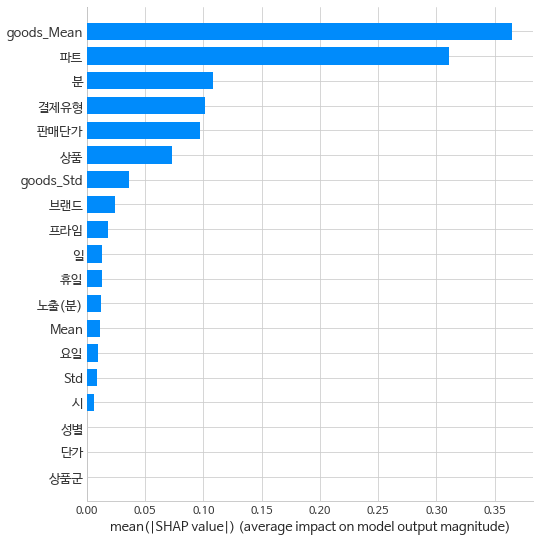

In [135]:
explainer = shap.TreeExplainer(cv_models[6])
shap_values = explainer.shap_values(cv_test_dataset[6])
shap.summary_plot(shap_values, train_x, plot_type="bar")

In [136]:
data_group['주방'] = data

## 가전

In [335]:
data = data_group['가전'].copy()

### Preprocessing

In [336]:
# 삼성 UHD TV
data.상품명 = data.상품명.str.replace('UN55NU7010FXKR', '55인치')
data.상품명 = data.상품명.str.replace('UN65NU7010FXKR', '65인치')
data.상품명 = data.상품명.str.replace('UN75NU7010FXKR', '75인치')
data.상품명 = data.상품명.str.replace('UN55NU7050F', '55인치')
data.상품명 = data.상품명.str.replace('UN65NU7050F', '65인치')
data.상품명 = data.상품명.str.replace('UN75NU7050F', '75인치')
data.상품명 = data.상품명.str.replace('UN55RU7150FXKR', '55인치')
data.상품명 = data.상품명.str.replace('UN65RU7150FXKR', '65인치')
data.상품명 = data.상품명.str.replace('UN75RU7150FXKR', '75인치')

# LG 울트라HD TV 
data.상품명 = data.상품명.str.replace('55UK6800HNC', '55인치')
data.상품명 = data.상품명.str.replace('55UM7900BNA', '55인치')
data.상품명 = data.상품명.str.replace('65UK6800HNC', '65인치')
data.상품명 = data.상품명.str.replace('65UM7900BNA', '65인치')
data.상품명 = data.상품명.str.replace('70UK6800HNC', '70인치')
data.상품명 = data.상품명.str.replace('70UK7400KNA', '70인치')
data.상품명 = data.상품명.str.replace('75UK6200KNB', '75인치')
data.상품명 = data.상품명.str.replace('75UK7400KNA', '75인치')
data.상품명 = data.상품명.str.replace('75UM7900BNA', '75인치')

# def extract_tv(x):
#     if 'TV' in x.상품명:
#         match = re.findall( r'(\d+)[인치]', x.상품명)
#         return match[0]
#     else:
#         return '해당없음'

# data['TV_인치'] = data.apply(lambda x: extract_tv(x), axis = 1)

data.상품명 = data.상품명.str.replace('TV 75인치','TV75인치')
data.상품명 = data.상품명.str.replace('TV 70인치','TV70인치')
data.상품명 = data.상품명.str.replace('TV 65인치','TV65인치')
data.상품명 = data.상품명.str.replace('TV 55인치','TV55인치')

In [337]:
data.상품명 = data.상품명.str.replace('2IN1형', ' 홈멀티 ', regex = False)
data.상품명 = data.상품명.str.replace('2in1', ' 홈멀티 ', regex = False)

data.상품명 = data.상품명.str.replace('홈멀티','홈멀티에어컨')
data.상품명 = data.상품명.str.replace('벽걸이','벽걸이에어컨')
data.상품명 = data.상품명.str.replace('스탠드','스탠드에어컨')

# air_type = ['홈멀티','스탠드','벽걸이']
# data = separate(data, air_type)

# def air_con(x, air_type_list):
#     type_ = []
#     for s in x.split():
#         if s in air_type_list:
#             type_.append(s)
#             return s
#     if len(type_) == 0:
#         return '해당없음' 

# data['에어컨'] = data.상품명.map(lambda x: air_con(x, air_type))
set(data[data.상품명.str.contains('딤채')].상품명)

{'(1등급)221L_딤채김치냉장고',
 '(1등급)221L_딤채김치냉장고(LDL22DHWJJ)',
 '(1등급)467L_딤채김치냉장고',
 '221L_딤채김치냉장고',
 '467L_딤채김치냉장고'}

### feature_상품

In [338]:
goods_가전 = ['홈멀티에어컨','벽걸이에어컨','스탠드에어컨','세탁기','노트북',
              '김치냉장고','냉장고','TV75인치','TV70인치','TV65인치','TV55인치',
              '건조기','공기청정기', '로봇청소기', '청소기','의류관리기']

data.상품명 = data.상품명.str.replace('공청기', '공기청정기')
data.상품명 = data.상품명.str.replace('로보킹 터보', '로봇청소기')

data = separate(data, goods_가전)
data.상품명 = data.상품명.str.replace('김치 냉장고', '김치냉장고')
data.상품명 = data.상품명.str.replace('로봇 청소기', '로봇청소기')
data['상품'] = data.상품명.map(lambda x: goods_name(x, goods_가전)) 

### feature_단가

In [339]:
sametime_count = data.groupby(['월','일','시','분','브랜드','상품','결제유형']).count()['상품명'].to_frame()
sametime_df_ = data.groupby(['월','일','시','분','브랜드','상품','결제유형','상품명']).mean()['판매단가'].to_frame()

sametime_df = sametime_df_[sametime_count.상품명 > 1]

Boolean Series key will be reindexed to match DataFrame index.


In [340]:
def cheap_expensive(x):
    try: 
        idx_list = sametime_df.loc[(x.월, x.일, x.시, x.분, x.브랜드, x.상품, x.결제유형)].values.reshape(-1).tolist()
        idx_list.sort()
        idx = idx_list.index(x.판매단가)/(len(idx_list)-1)
        if idx == 0:
            return '하'
        if idx == 0.5:
            return '중'
        if idx == 1:
            return '상'
    except KeyError:
        return '해당없음'

data['단가'] = data.apply(lambda x: cheap_expensive(x), axis=1)

### feature_Statistics

In [341]:
mean_df = data.groupby(['요일','시']).mean()['취급액_로그'].to_frame()
std_df = data.groupby(['요일','시']).std()['취급액_로그'].to_frame()

def statistics(x):
    mean = mean_df.loc[(x.요일, x.시)].values[0]
    std = std_df.loc[(x.요일, x.시)].values[0]
    x['Mean'] = mean
    x['Std'] = std

    return x

data = data.apply(lambda x: statistics(x), axis =1)

In [342]:
goods_mean_df = data.groupby(['요일','시','결제유형','상품']).mean()['취급액_로그'].to_frame()
goods_std_df = data.groupby(['요일','시','결제유형','상품']).std()['취급액_로그'].to_frame()

def goods_statistics(x):
    goods_mean = goods_mean_df.loc[(x.요일, x.시, x.결제유형, x.상품)].values[0]
    goods_std = goods_std_df.loc[(x.요일, x.시, x.결제유형, x.상품)].values[0]
    x['goods_Mean'] = goods_mean
    x['goods_Std'] = goods_std

    return x

data = data.apply(lambda x:goods_statistics(x), axis =1)

In [343]:
data.to_csv('group_가전.csv')

### Train CATBoost

In [145]:
month = list(set(data.월))

raw_x = data.drop(columns=['취급액_로그','상품명'])
raw_y = data[['취급액_로그','월']]

cv_test = {}
cv_predict = {}
cv_scores = {}
cv_models = {}
cv_test_dataset = {}

for m in month:

    # try:

    test_x = raw_x[raw_x.월 == m].drop(columns = ['월'])
    test_y = raw_y[raw_y.월 == m].취급액_로그
    train_x = raw_x.drop(index = test_x.index, columns = ['월'])
    train_y = raw_y.drop(index = test_y.index).취급액_로그

    # test_x = mmscaler.fit_transform(test_x)
    # train_x = mmscaler.fit_transform(train_x)

    train_y = train_y.to_numpy().reshape(-1)
    test_y = test_y.to_numpy().reshape(-1)

    cat_features_train = np.where((train_x.dtypes != np.float)&(train_x.dtypes != np.int))[0]
    cat_features_test = np.where((test_x.dtypes != np.float)&(test_x.dtypes != np.int))[0]
    
    train_dataset = Pool(train_x, label = train_y, cat_features=cat_features_train)
    test_dataset = Pool(test_x, label = test_y, cat_features=cat_features_test)
    CBR = model.fit(train_dataset,  
                    eval_set = test_dataset,
                    use_best_model = True,      
                    verbose_eval = 500,
                    plot = False)
    predict_test = model.predict(test_x)

    test_y = np.exp(test_y)
    predict_test = np.exp(predict_test)

    cv_test.update({m:test_y})
    cv_predict.update({m: predict_test})

    mape = mean_absolute_percentage_error(test_y, predict_test)
    print(f'{m}월 MAPE:', mape)

    cv_scores.update({m:mape})
    cv_models.update({m:model})
    cv_test_dataset.update({m:test_dataset})

    print(' ')

0:	learn: 0.0412664	test: 0.0432409	best: 0.0432409 (0)	total: 16.3ms	remaining: 32.6s
500:	learn: 0.0193312	test: 0.0254651	best: 0.0253068 (199)	total: 6.65s	remaining: 19.9s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.02530684774
bestIteration = 199

Shrink model to first 200 iterations.
1월 MAPE: 48.708249600490156
 
0:	learn: 0.0413408	test: 0.0413128	best: 0.0413128 (0)	total: 15.7ms	remaining: 31.3s
500:	learn: 0.0193115	test: 0.0249328	best: 0.0249064 (472)	total: 6.62s	remaining: 19.8s
1000:	learn: 0.0179542	test: 0.0248545	best: 0.0248248 (970)	total: 13.3s	remaining: 13.3s
1500:	learn: 0.0171156	test: 0.0248464	best: 0.0248058 (1291)	total: 20s	remaining: 6.65s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.02480584234
bestIteration = 1291

Shrink model to first 1292 iterations.
2월 MAPE: 44.38696701219451
 
0:	learn: 0.0415144	test: 0.0407431	best: 0.0407431 (0)	total: 15.2ms	remaining: 30.5s
500:	learn: 0.0194925	test: 0.0248835

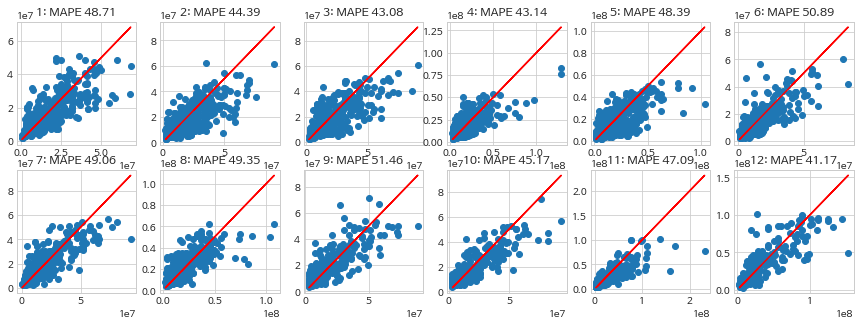

In [146]:
plot_result(cv_test, cv_predict, cv_scores)

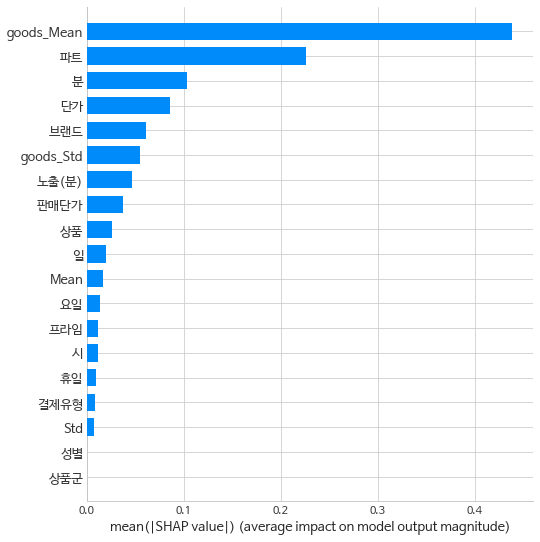

In [147]:
explainer = shap.TreeExplainer(cv_models[6])
shap_values = explainer.shap_values(cv_test_dataset[6])
shap.summary_plot(shap_values, train_x, plot_type="bar",)

In [148]:
data_group['가전'] = data

## 이미용

In [344]:
data = data_group['이미용'].copy()

### feature_상품

In [345]:
goods_이미용 = ['스킨케어','선케어','베이스메이크업','마스크/팩','헤어케어',
                '헤어스타일링','클렌징','색조메이크업','바디케어','네일케어','뷰티소품']

In [346]:
data.상품명 = data.상품명.str.replace('기초세트', '스킨케어')
data.상품명 = data.상품명.str.replace('링클 리프트', '스킨케어')
data.상품명 = data.상품명.str.replace('세럼', '스킨케어')
data.상품명 = data.상품명.str.replace('에센스', '스킨케어')
data.상품명 = data.상품명.str.replace('더오리진 크림세트', '스킨케어')
data.상품명 = data.상품명.str.replace('코코넛크림', '스킨케어')


data.상품명 = data.상품명.str.replace('헤어', '헤어케어')
data.상품명 = data.상품명.str.replace('샴푸', '헤어케어')
data.상품명 = data.상품명.str.replace('트리트먼트', '헤어케어')

data.상품명 = data.상품명.str.replace('파운데이션', '베이스메이크업')
data.상품명 = data.상품명.str.replace('샤이닝 쿠션', '베이스메이크업')


data.상품명 = data.상품명.str.replace('썬스틱', '선케어')
data.상품명 = data.상품명.str.replace('선스틱', '선케어')
data.상품명 = data.상품명.str.replace('선쿠션', '선케어')

data.상품명 = data.상품명.str.replace('클린샤워', '바디케어')
data.상품명 = data.상품명.str.replace('풋케어', '바디케어')

data.상품명 = data.상품명.str.replace('오일 워시', '클렌징')
data.상품명 = data.상품명.str.replace('클렌져', '클렌징')
data.상품명 = data.상품명.str.replace('클렌저', '클렌징')

data.상품명 = data.상품명.str.replace('마스크', '마스크/팩')
data.상품명 = data.상품명.str.replace('팩', '마스크/팩')

data.상품명 = data.상품명.str.replace('아이스타일러', '색조메이크업')
data.상품명 = data.상품명.str.replace('아이라이너', '색조메이크업')
data.상품명 = data.상품명.str.replace('틴트', '색조메이크업')
data.상품명 = data.상품명.str.replace('아이브로우', '색조메이크업')
data.상품명 = data.상품명.str.replace('립스틱', '색조메이크업')

data.상품명 = data.상품명.str.replace('네일', '네일케어')

data.상품명 = data.상품명.str.replace('펌', '헤어스타일링')
data.상품명 = data.상품명.str.replace('퍼머', '헤어스타일링')
data.상품명 = data.상품명.str.replace('볼륨스프레이', '헤어스타일링')


data = separate(data, goods_이미용)
data['상품'] = data.상품명.map(lambda x: goods_name(x, goods_이미용)) 
data['상품'] = data.상품.map(lambda x: '뷰티소품' if type(x) != str else x)

In [347]:
data.head()

,노출(분),상품명,상품군,판매단가,월,일,시,요일,휴일,프라임,파트,브랜드,분,취급액_로그,결제유형,성별,상품
방송일시,,,,,,,,,,,,,,,,,
2019-01-01 17:00:00,20.0,비버리힐스폴로클럽 남성 스킨케어 (2018FW골드),이미용,39800,1,1,17,Tuesday,2,1,First,비버리힐스폴로클럽,00,17.558855,해당없음,남성,스킨케어
2019-01-01 17:20:00,20.0,비버리힐스폴로클럽 남성 스킨케어 (2018FW골드),이미용,39800,1,1,17,Tuesday,2,1,Middle,비버리힐스폴로클럽,20,18.112714,해당없음,남성,스킨케어
2019-01-01 17:40:00,20.0,비버리힐스폴로클럽 남성 스킨케어 (2018FW골드),이미용,39800,1,1,17,Tuesday,2,1,Later,비버리힐스폴로클럽,40,18.489302,해당없음,남성,스킨케어
2019-01-03 08:00:00,20.0,엘렌실라 달팽이크림(콜라겐5+ 마스크/팩 트3),이미용,79000,1,3,8,Thursday,0,3,First,엘렌실라,00,16.430348,해당없음,해당없음,마스크/팩
2019-01-03 08:20:00,20.0,엘렌실라 달팽이크림(콜라겐5+ 마스크/팩 트3),이미용,79000,1,3,8,Thursday,0,3,Middle,엘렌실라,20,17.103465,해당없음,해당없음,마스크/팩


### feature_Statistics

In [348]:
mean_df = data.groupby(['요일','시']).mean()['취급액_로그'].to_frame()
std_df = data.groupby(['요일','시']).std()['취급액_로그'].to_frame()

def statistics(x):
    mean = mean_df.loc[(x.요일, x.시)].values[0]
    std = std_df.loc[(x.요일, x.시)].values[0]
    x['Mean'] = mean
    x['Std'] = std

    return x

data = data.apply(lambda x: statistics(x), axis =1)

In [349]:
goods_mean_df = data.groupby(['요일','시','결제유형','상품']).mean()['취급액_로그'].to_frame()
goods_std_df = data.groupby(['요일','시','결제유형','상품']).std()['취급액_로그'].to_frame()

def goods_statistics(x):
    goods_mean = goods_mean_df.loc[(x.요일, x.시, x.결제유형, x.상품)].values[0]
    goods_std = goods_std_df.loc[(x.요일, x.시, x.결제유형, x.상품)].values[0]
    x['goods_Mean'] = goods_mean
    x['goods_Std'] = goods_std

    return x

data = data.apply(lambda x:goods_statistics(x), axis =1)

In [350]:
data.to_csv('group_이미용.csv')

### Train CATBoost

In [155]:
month = list(set(data.월))

raw_x = data.drop(columns=['취급액_로그'])
raw_y = data[['취급액_로그','월']]

cv_test = {}
cv_predict = {}
cv_scores = {}
cv_models = {}
cv_test_dataset = {}

for m in month:

    # try:

    test_x = raw_x[raw_x.월 == m].drop(columns = ['월'])
    test_y = raw_y[raw_y.월 == m].취급액_로그
    train_x = raw_x.drop(index = test_x.index, columns = ['월'])
    train_y = raw_y.drop(index = test_y.index).취급액_로그

    # test_x = mmscaler.fit_transform(test_x)
    # train_x = mmscaler.fit_transform(train_x)

    train_y = train_y.to_numpy().reshape(-1)
    test_y = test_y.to_numpy().reshape(-1)

    cat_features_train = np.where((train_x.dtypes != np.float)&(train_x.dtypes != np.int))[0]
    cat_features_test = np.where((test_x.dtypes != np.float)&(test_x.dtypes != np.int))[0]
    
    train_dataset = Pool(train_x, label = train_y, cat_features=cat_features_train)
    test_dataset = Pool(test_x, label = test_y, cat_features=cat_features_test)
    CBR = model.fit(train_dataset,  
                    eval_set = test_dataset,
                    use_best_model = True,      
                    verbose_eval = 500,
                    plot = False)
    predict_test = model.predict(test_x)

    test_y = np.exp(test_y)
    predict_test = np.exp(predict_test)

    cv_test.update({m:test_y})
    cv_predict.update({m: predict_test})

    mape = mean_absolute_percentage_error(test_y, predict_test)
    print(f'{m}월 MAPE:', mape)

    cv_scores.update({m:mape})
    cv_models.update({m:model})
    cv_test_dataset.update({m:test_dataset})

    print(' ')

0:	learn: 0.0324771	test: 0.0287508	best: 0.0287508 (0)	total: 5.35ms	remaining: 10.7s
500:	learn: 0.0047765	test: 0.0120119	best: 0.0118072 (90)	total: 4s	remaining: 12s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.01180724695
bestIteration = 90

Shrink model to first 91 iterations.
1월 MAPE: 20.568202996317954
 
0:	learn: 0.0324726	test: 0.0271593	best: 0.0271593 (0)	total: 4.31ms	remaining: 8.62s
500:	learn: 0.0049331	test: 0.0090344	best: 0.0089259 (313)	total: 4s	remaining: 12s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.008925900601
bestIteration = 313

Shrink model to first 314 iterations.
2월 MAPE: 16.646192681123892
 
0:	learn: 0.0322700	test: 0.0238380	best: 0.0238380 (0)	total: 8.75ms	remaining: 17.5s
500:	learn: 0.0049648	test: 0.0110698	best: 0.0110026 (311)	total: 4s	remaining: 12s
1000:	learn: 0.0036516	test: 0.0109919	best: 0.0109133 (896)	total: 8.1s	remaining: 8.09s
1500:	learn: 0.0029277	test: 0.0110884	best: 0.0108826 (

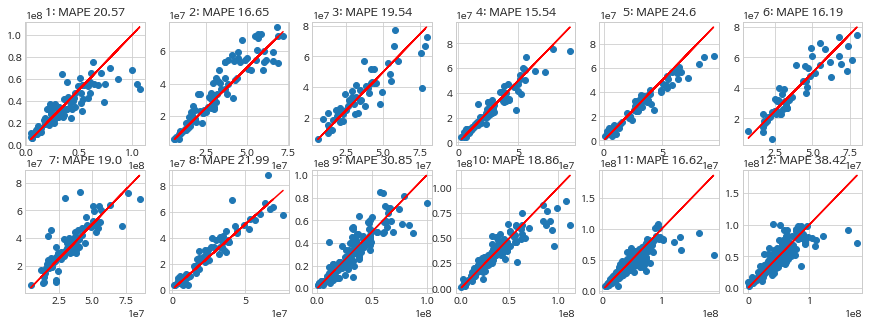

In [156]:
plot_result(cv_test, cv_predict, cv_scores)

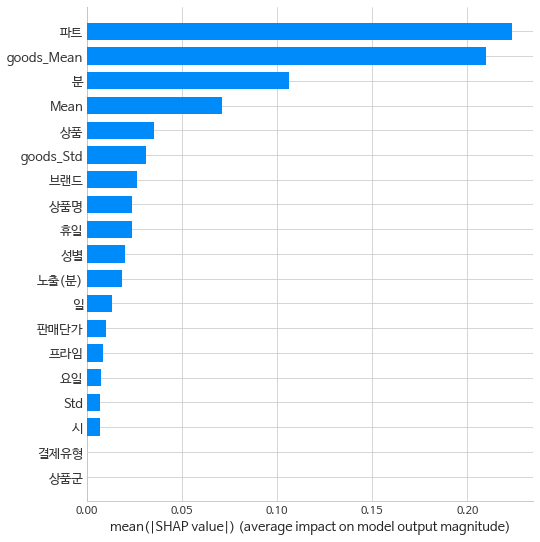

In [157]:
explainer = shap.TreeExplainer(cv_models[6])
shap_values = explainer.shap_values(cv_test_dataset[6])
shap.summary_plot(shap_values, train_x, plot_type="bar",)

In [158]:
data_group['이미용'] = data

## 농수축

In [381]:
data = data_group['농수축'].copy()

In [382]:
## 오버피팅 위험으로 상품별 통계치 변수는 추가하지 않음

mean_df = data.groupby(['요일','시']).mean()['취급액_로그'].to_frame()
std_df = data.groupby(['요일','시']).std()['취급액_로그'].to_frame()

def statistics(x):
    mean = mean_df.loc[(x.요일, x.시)].values[0]
    std = std_df.loc[(x.요일, x.시)].values[0]
    x['Mean'] = mean
    x['Std'] = std

    return x

data = data.apply(lambda x: statistics(x), axis =1)

In [383]:
data.to_csv('group_농수축.csv')

### feature_상품
전처리의 의미가 크지 않다고 판단하여 전처리를 하지 않음

In [278]:
# goods_농수축 = ['농산물','수산물','축산물','즉석탕','김치','건어물',
                # '쌀','건강','과일','떡',]

In [281]:
# data.상품명 = data.상품명.str.replace('손질', '수산물')
# data.상품명 = data.상품명.str.replace('활전복', '수산물 전복')
# data.상품명 = data.상품명.str.replace('갈치', '수산물 갈치')
# data.상품명 = data.상품명.str.replace('고등어', '수산물 고등어')
# data.상품명 = data.상품명.str.replace('홍어', '수산물 홍어')
# data.상품명 = data.상품명.str.replace('굴비', '수산물 굴비')
# data.상품명 = data.상품명.str.replace('참굴', '수산물 참굴')
# data.상품명 = data.상품명.str.replace('꽃게', '수산물 꽃게')
# data.상품명 = data.상품명.str.replace('장어', '수산물 장어')
# data.상품명 = data.상품명.str.replace('새우', '수산물 새우')
# data.상품명 = data.상품명.str.replace('랍스터', '수산물 랍스터')
# data.상품명 = data.상품명.str.replace('조기', '수산물 조기')
# data.상품명 = data.상품명.str.replace('랍스터', '수산물 랍스터')

# data.상품명 = data.상품명.str.replace('감자탕', '즉석탕')
# data.상품명 = data.상품명.str.replace('곰탕', '즉석탕')
# data.상품명 = data.상품명.str.replace('도가니탕', '즉석탕')
# data.상품명 = data.상품명.str.replace('갈비탕', '즉석탕')
# data.상품명 = data.상품명.str.replace('삼계탕', '즉석탕')
# data.상품명 = data.상품명.str.replace('소한마리', '즉석탕')
# data.상품명 = data.상품명.str.replace('전골', '즉석탕')
# data.상품명 = data.상품명.str.replace('국밥', '즉석탕')

# data.상품명 = data.상품명.str.replace('한우', '축산물 구이')
# data.상품명 = data.상품명.str.replace('구이', '축산물 구이')
# data.상품명 = data.상품명.str.replace('치마살', '축산물 치마살')
# data.상품명 = data.상품명.str.replace('LA갈비', '축산물 갈비')
# data.상품명 = data.상품명.str.replace('LA 갈비', '축산물 갈비')
# data.상품명 = data.상품명.str.replace('오리로스', '축산물 오리로스')

# data.상품명 = data.상품명.str.replace('황태', '건어물 황태')
# data.상품명 = data.상품명.str.replace('쥐포', '건어물 쥐포')

# data.상품명 = data.상품명.str.replace('꿀', '건강 꿀')
# data.상품명 = data.상품명.str.replace('즙', '건강 즙')
# data.상품명 = data.상품명.str.replace('머루원액', '건강 머루원액')
# data.상품명 = data.상품명.str.replace('매실', '건강 매실')

# data.상품명 = data.상품명.str.replace('오렌지', '과일')
# data.상품명 = data.상품명.str.replace('사과', '과일')
# data.상품명 = data.상품명.str.replace('머스캣', '과일')
# data.상품명 = data.상품명.str.replace('한라봉', '과일')

# # data.상품명 = data.상품명.str.replace('탕', '즉석국/즉석탕')
# # data.상품명 = data.상품명.str.replace('국수', '면') 
# # data.상품명 = data.상품명.str.replace('갈비', '축산')

# # data.상품명 = data.상품명.str.replace('옥수수', '농산물')

# data = separate(data, goods_농수축)

# data['상품'] = data.상품명.map(lambda x: goods_name(x, goods_농수축)) 
# #data['상품'] = data.상품.map(lambda x: '뷰티소품' if type(x) != str else x)

In [164]:
# sametime_count = data.groupby(['월','일','시','분','브랜드','상품','결제유형']).count()['상품명'].to_frame()
# sametime_df_ = data.groupby(['월','일','시','분','브랜드','상품','결제유형','상품명']).mean()['판매단가'].to_frame()

# sametime_df = sametime_df_[sametime_count.상품명 > 1]
# sametime_df[sametime_df.판매단가!=38900]

Boolean Series key will be reindexed to match DataFrame index.


,,,,,,,,판매단가
월,일,시,분,브랜드,상품,결제유형,상품명,


## 가구

In [351]:
data = data_group['가구'].copy()

### Preprocessing

In [352]:
data.상품명 = data.상품명.str.replace('싱글사이즈', '싱글')
data.상품명 = data.상품명.str.replace('퀸사이즈', '퀸')
data.상품명 = data.상품명.str.replace('Q 퀸', '퀸')
data.상품명 = data.상품명.str.replace('Q(퀸)', '퀸', regex = False)

data.상품명 = data.상품명.str.replace('킹사이즈', '킹')
data.상품명 = data.상품명.str.replace('K 킹', '킹')
data.상품명 = data.상품명.str.replace('K(킹)', '킹', regex = False)

data.상품명 = data.상품명.str.replace('SK(슈퍼킹)', '슈퍼킹', regex = False)
data.상품명 = data.상품명.str.replace('SS 슈퍼싱글', '슈퍼싱글', regex = False)
data.상품명 = data.상품명.str.replace('SS(슈퍼싱글)', '슈퍼싱글', regex = False)

data.상품명 = data.상품명.str.replace('K', '킹', regex = False)
data.상품명 = data.상품명.str.replace('Q', '퀸', regex = False)
data.상품명 = data.상품명.str.replace('SS', '슈퍼싱글', regex = False)
data.상품명 = data.상품명.str.replace('S', '싱글', regex = False)

# bedsize_list = ['킹','퀸','싱글','슈퍼싱글']
# def bedsize(x):
#     size = []
#     for s in x.split():
#         if s in bedsize_list:
#             return s
#             size.append(s)
#     if len(size) == 0:
#         return '해당없음'
        

# data['침대사이즈'] = data.상품명.map(lambda x: bedsize(x))

data.상품명 = data.상품명.str.replace('침대 킹', '킹침대', regex = False)
data.상품명 = data.상품명.str.replace('침대 퀸', '퀸침대', regex = False)
data.상품명 = data.상품명.str.replace('침대 슈퍼싱글', '슈퍼싱글침대', regex = False)
data.상품명 = data.상품명.str.replace('침대 퀸', '퀸흙침대', regex = False)
data.상품명 = data.상품명.str.replace('침대 싱글', '싱글흙침대', regex = False)

### feature_상품

In [353]:
goods_가구 = ['퀸침대','킹침대','슈퍼싱글침대','퀸흙침대','싱글흙침대',
              '리클라이너','소파','수납장','욕실가구','흙카우치','가구세트']

data.상품명 = data.상품명.str.replace('리클라이닝', '리클라이너', regex = False)
data.상품명 = data.상품명.str.replace('서랍장', '수납장', regex = False)
data.상품명 = data.상품명.str.replace('붙박이장', '수납장', regex = False)
data.상품명 = data.상품명.str.replace('거실장', '수납장', regex = False)

data.상품명 = data.상품명.str.replace('바스', '욕실가구', regex = False)

data = separate(data, goods_가구)
data['상품'] = data.상품명.map(lambda x: goods_name(x, goods_가구)) 
data['상품'] = data.상품.map(lambda x: '가구세트' if type(x) != str else x)

### feature_단가

In [354]:
sametime_count = data.groupby(['월','일','시','분','브랜드','상품','결제유형']).count()['상품명'].to_frame()
sametime_df_ = data.groupby(['월','일','시','분','브랜드','상품','결제유형','상품명']).mean()['판매단가'].to_frame()

sametime_df = sametime_df_[sametime_count.상품명 > 1]
sametime_df

Boolean Series key will be reindexed to match DataFrame index.


판매단가
월  일  시  분  브랜드  상품  결제유형 상품명                               
2  28 20 00 한샘   수납장 무이자  한샘 HG 화이트 실버슬림 수납장 (3.2m)  1199000
                          한샘 HG 화이트 실버슬림 수납장 (4.2m)  1499000
                     일시불  한샘 HG 화이트 실버슬림 수납장 (3.2m)  1099000
                          한샘 HG 화이트 실버슬림 수납장 (4.2m)  1399000
         20 한샘   수납장 무이자  한샘 HG 화이트 실버슬림 수납장 (2.2m)   749000
...                                                      ...
12 9  0  20 보루네오 소파  무이자  [보루네오] 피올레 천연소가죽 소파 4인용     949000
                          [보루네오] 피올레 천연소가죽 소파 6인용    1249000
                     일시불  [보루네오] 피올레 천연소가죽 소파 3인용     699000
                          [보루네오] 피올레 천연소가죽 소파 4인용     899000
                          [보루네오] 피올레 천연소가죽 소파 6인용    1199000

[649 rows x 1 columns]

In [355]:
def cheap_expensive(x):
    try: 
        idx_list = sametime_df.loc[(x.월, x.일, x.시, x.분, x.브랜드, x.상품, x.결제유형)].values.reshape(-1).tolist()
        idx_list.sort()
        idx = idx_list.index(x.판매단가)/(len(idx_list)-1)
        if idx == 0:
            return '하'
        if idx == 0.5:
            return '중'
        if idx == 1:
            return '상'
    except KeyError:
        return '해당없음'

data['단가'] = data.apply(lambda x: cheap_expensive(x), axis=1)

### feature_Statistics

In [356]:
mean_df = data.groupby(['요일','시']).mean()['취급액_로그'].to_frame()
std_df = data.groupby(['요일','시']).std()['취급액_로그'].to_frame()

data = data.apply(lambda x: statistics(x), axis =1)

goods_mean_df = data.groupby(['요일','시','결제유형','상품']).mean()['취급액_로그'].to_frame()
goods_std_df = data.groupby(['요일','시','결제유형','상품']).std()['취급액_로그'].to_frame()

data = data.apply(lambda x:goods_statistics(x), axis =1)

In [358]:
data.to_csv('group_가구.csv')

### Train CATBoost

In [172]:
month = list(set(data.월))

raw_x = data.drop(columns=['취급액_로그','상품명'])
raw_y = data[['취급액_로그','월']]

cv_test = {}
cv_predict = {}
cv_scores = {}
cv_models = {}
cv_test_dataset = {}

for m in month:

    # try:

    test_x = raw_x[raw_x.월 == m].drop(columns = ['월'])
    test_y = raw_y[raw_y.월 == m].취급액_로그
    train_x = raw_x.drop(index = test_x.index, columns = ['월'])
    train_y = raw_y.drop(index = test_y.index).취급액_로그

    # test_x = mmscaler.fit_transform(test_x)
    # train_x = mmscaler.fit_transform(train_x)

    train_y = train_y.to_numpy().reshape(-1)
    test_y = test_y.to_numpy().reshape(-1)

    cat_features_train = np.where((train_x.dtypes != np.float)&(train_x.dtypes != np.int))[0]
    cat_features_test = np.where((test_x.dtypes != np.float)&(test_x.dtypes != np.int))[0]
    
    train_dataset = Pool(train_x, label = train_y, cat_features=cat_features_train)
    test_dataset = Pool(test_x, label = test_y, cat_features=cat_features_test)
    CBR = model.fit(train_dataset,  
                    eval_set = test_dataset,
                    use_best_model = True,      
                    verbose_eval = 500,
                    plot = False)
    predict_test = model.predict(test_x)

    test_y = np.exp(test_y)
    predict_test = np.exp(predict_test)

    cv_test.update({m:test_y})
    cv_predict.update({m: predict_test})

    mape = mean_absolute_percentage_error(test_y, predict_test)
    print(f'{m}월 MAPE:', mape)

    cv_scores.update({m:mape})
    cv_models.update({m:model})
    cv_test_dataset.update({m:test_dataset})

    print(' ')

0:	learn: 0.0451899	test: 0.0470516	best: 0.0470516 (0)	total: 11.6ms	remaining: 23.3s
500:	learn: 0.0161260	test: 0.0204380	best: 0.0200107 (245)	total: 4.56s	remaining: 13.7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.02001073159
bestIteration = 245

Shrink model to first 246 iterations.
2월 MAPE: 34.41148399078705
 
0:	learn: 0.0455516	test: 0.0436187	best: 0.0436187 (0)	total: 9.09ms	remaining: 18.2s
500:	learn: 0.0162376	test: 0.0204702	best: 0.0202276 (326)	total: 4.54s	remaining: 13.6s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.02022757397
bestIteration = 326

Shrink model to first 327 iterations.
3월 MAPE: 35.626723143364245
 
0:	learn: 0.0457449	test: 0.0437928	best: 0.0437928 (0)	total: 5.43ms	remaining: 10.9s
500:	learn: 0.0148143	test: 0.0258072	best: 0.0257623 (489)	total: 4.5s	remaining: 13.5s
1000:	learn: 0.0128431	test: 0.0256849	best: 0.0256815 (993)	total: 9s	remaining: 8.98s
Stopped by overfitting detector  (500 itera

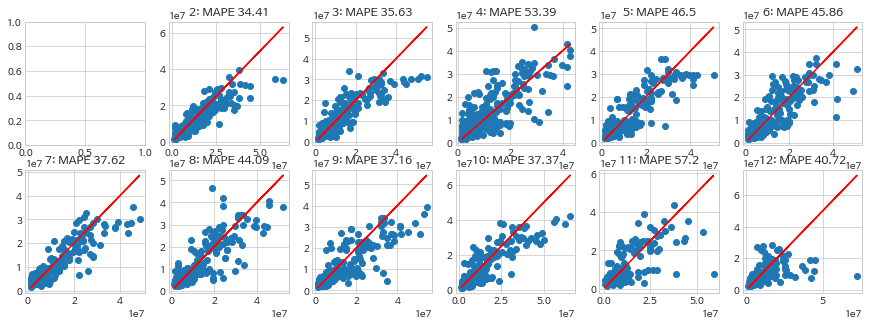

In [173]:
plot_result(cv_test, cv_predict, cv_scores)

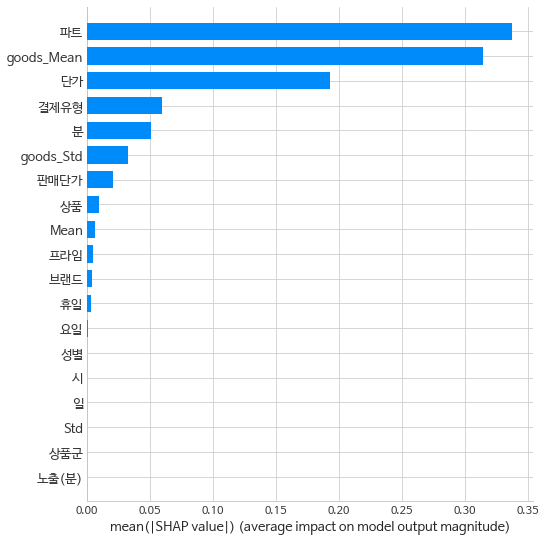

In [174]:
explainer = shap.TreeExplainer(cv_models[6])
shap_values = explainer.shap_values(cv_test_dataset[6])
shap.summary_plot(shap_values, train_x, plot_type="bar",)

In [175]:
data_group['가구'] = data

## 침구

In [359]:
data = data_group['침구'].copy()

### Preprocessing

In [360]:
data.상품명 = data.상품명.str.replace('싱글사이즈', '싱글')
data.상품명 = data.상품명.str.replace('퀸사이즈', '퀸')
data.상품명 = data.상품명.str.replace('Q 퀸', '퀸')
data.상품명 = data.상품명.str.replace('Q(퀸)', '퀸', regex = False)

data.상품명 = data.상품명.str.replace('킹사이즈', '킹')
data.상품명 = data.상품명.str.replace('K 킹', '킹')
data.상품명 = data.상품명.str.replace('K(킹)', '킹', regex = False)

data.상품명 = data.상품명.str.replace('SK(슈퍼킹)', '슈퍼킹', regex = False)
data.상품명 = data.상품명.str.replace('SS 슈퍼싱글', '슈퍼싱글', regex = False)
data.상품명 = data.상품명.str.replace('SS(슈퍼싱글)', '슈퍼싱글', regex = False)

data.상품명 = data.상품명.str.replace('K', '킹', regex = False)
data.상품명 = data.상품명.str.replace('Q', '퀸', regex = False)
data.상품명 = data.상품명.str.replace('SS', '슈퍼싱글', regex = False)
data.상품명 = data.상품명.str.replace('S', '싱글', regex = False)

data = separate(data,['킹','퀸','슈퍼싱글','싱글','슈퍼킹'])

data.상품명 = data.상품명.str.replace('슈퍼 킹', '슈퍼킹', regex = False)
data.상품명 = data.상품명.str.replace('슈퍼 싱글', '슈퍼싱글', regex = False)

data.상품명 = data.상품명.str.replace('침구세트 슈퍼킹', '슈퍼킹침구세트', regex = False)
data.상품명 = data.상품명.str.replace('침구세트 킹', '킹침구세트', regex = False)
data.상품명 = data.상품명.str.replace('침구세트 퀸', '퀸침구세트', regex = False)
data.상품명 = data.상품명.str.replace('침구세트 슈퍼싱글', '슈퍼싱글침구세트', regex = False)
data.상품명 = data.상품명.str.replace('침구세트 싱글', '싱글침구세트', regex = False)

data.상품명 = data.상품명.str.replace('슈퍼킹 침구세트', '슈퍼킹침구세트', regex = False)
data.상품명 = data.상품명.str.replace('킹 침구세트', '킹침구세트', regex = False)
data.상품명 = data.상품명.str.replace('퀸 침구세트', '퀸침구세트', regex = False)
data.상품명 = data.상품명.str.replace('슈퍼싱글 침구세트', '슈퍼싱글침구세트', regex = False)
data.상품명 = data.상품명.str.replace('싱글 침구세트', '싱글침구세트', regex = False)

### feature_상품

In [361]:
goods_침구 = ['킹침구세트','퀸침구세트','슈퍼싱글침구세트','싱글침구세트','커튼','카페트']

data.상품명 = data.상품명.str.replace('리클라이닝', '리클라이너', regex = False)
data.상품명 = data.상품명.str.replace('서랍장', '수납장', regex = False)
data.상품명 = data.상품명.str.replace('붙박이장', '수납장', regex = False)
data.상품명 = data.상품명.str.replace('거실장', '수납장', regex = False)

data.상품명 = data.상품명.str.replace('바스', '욕실가구', regex = False)
data.상품명 = data.상품명.str.replace('대자리', '카페트', regex = False)


data = separate(data, goods_침구)
data['상품'] = data.상품명.map(lambda x: goods_name(x, goods_침구)) 
#data['상품'] = data.상품.map(lambda x: '가구세트' if type(x) != str else x)

### feature_단가

In [362]:
sametime_count = data.groupby(['월','일','시','분','브랜드','상품','결제유형']).count()['상품명'].to_frame()
sametime_df_ = data.groupby(['월','일','시','분','브랜드','상품','결제유형','상품명']).mean()['판매단가'].to_frame()

sametime_df = sametime_df_[sametime_count.상품명 > 1]
sametime_df

Boolean Series key will be reindexed to match DataFrame index.


판매단가
월  일  시 분  브랜드 상품    결제유형 상품명                                
4  24 1 00 한샘  커튼    일시불  [한샘] 호텔식 레일 암막 커튼 세트(슈퍼특대형)  229000
                          [한샘] 호텔식 레일 암막 커튼 세트(중형)     159000
        20 한샘  커튼    무이자  [한샘] 호텔식 레일 암막 커튼 세트(대형)     189000
                          [한샘] 호텔식 레일 암막 커튼 세트(슈퍼특대형)  239000
                          [한샘] 호텔식 레일 암막 커튼 세트(중형)     169000
...                                                       ...
11 6  1 20 보몽드 킹침구세트 해당없음 보몽드 헤르만 착번아웃 극세사 킹침구세트        79900
        40 보몽드 킹침구세트 해당없음 보몽드 헤르만 착번아웃 극세사 슈퍼 킹침구세트     89900
                          보몽드 헤르만 착번아웃 극세사 킹침구세트        79900
      2 00 보몽드 킹침구세트 해당없음 보몽드 헤르만 착번아웃 극세사 슈퍼 킹침구세트     89900
                          보몽드 헤르만 착번아웃 극세사 킹침구세트        79900

[186 rows x 1 columns]

In [363]:
def cheap_expensive(x):
    try: 
        idx_list = sametime_df.loc[(x.월, x.일, x.시, x.분, x.브랜드, x.상품, x.결제유형)].values.reshape(-1).tolist()
        idx_list.sort()
        idx = idx_list.index(x.판매단가)/(len(idx_list)-1)
        if idx == 0:
            return '하'
        if idx == 1:
            return '상'
        else:
            return '중'
    except KeyError:
        return '해당없음'

data['단가'] = data.apply(lambda x: cheap_expensive(x), axis=1)

### feature_Statistics

In [364]:
mean_df = data.groupby(['요일','시']).mean()['취급액_로그'].to_frame()
std_df = data.groupby(['요일','시']).std()['취급액_로그'].to_frame()

data = data.apply(lambda x: statistics(x), axis =1)

goods_mean_df = data.groupby(['요일','시','결제유형','상품']).mean()['취급액_로그'].to_frame()
goods_std_df = data.groupby(['요일','시','결제유형','상품']).std()['취급액_로그'].to_frame()

data = data.apply(lambda x:goods_statistics(x), axis =1)

In [365]:
data.to_csv('group_침구.csv')

### Train CATBoost

In [182]:
month = list(set(data.월))

raw_x = data.drop(columns=['취급액_로그','상품명'])
raw_y = data[['취급액_로그','월']]

cv_test = {}
cv_predict = {}
cv_scores = {}
cv_models = {}
cv_test_dataset = {}

for m in month:

    # try:

    test_x = raw_x[raw_x.월 == m].drop(columns = ['월'])
    test_y = raw_y[raw_y.월 == m].취급액_로그
    train_x = raw_x.drop(index = test_x.index, columns = ['월'])
    train_y = raw_y.drop(index = test_y.index).취급액_로그

    # test_x = mmscaler.fit_transform(test_x)
    # train_x = mmscaler.fit_transform(train_x)

    train_y = train_y.to_numpy().reshape(-1)
    test_y = test_y.to_numpy().reshape(-1)

    cat_features_train = np.where((train_x.dtypes != np.float)&(train_x.dtypes != np.int))[0]
    cat_features_test = np.where((test_x.dtypes != np.float)&(test_x.dtypes != np.int))[0]
    
    train_dataset = Pool(train_x, label = train_y, cat_features=cat_features_train)
    test_dataset = Pool(test_x, label = test_y, cat_features=cat_features_test)
    CBR = model.fit(train_dataset,  
                    eval_set = test_dataset,
                    use_best_model = True,      
                    verbose_eval = 500,
                    plot = False)
    predict_test = model.predict(test_x)

    test_y = np.exp(test_y)
    predict_test = np.exp(predict_test)

    cv_test.update({m:test_y})
    cv_predict.update({m: predict_test})

    mape = mean_absolute_percentage_error(test_y, predict_test)
    print(f'{m}월 MAPE:', mape)

    cv_scores.update({m:mape})
    cv_models.update({m:model})
    cv_test_dataset.update({m:test_dataset})

    print(' ')

0:	learn: 0.0362820	test: 0.0781812	best: 0.0781812 (0)	total: 6.21ms	remaining: 12.4s
500:	learn: 0.0051927	test: 0.0414137	best: 0.0413972 (483)	total: 2.64s	remaining: 7.91s
1000:	learn: 0.0034502	test: 0.0406460	best: 0.0406200 (984)	total: 5.29s	remaining: 5.28s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.04062004295
bestIteration = 984

Shrink model to first 985 iterations.
4월 MAPE: 98.46515283577716
 
0:	learn: 0.0401979	test: 0.0315071	best: 0.0315071 (0)	total: 6.74ms	remaining: 13.5s
500:	learn: 0.0051457	test: 0.0181907	best: 0.0163665 (37)	total: 2.85s	remaining: 8.52s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.01636649921
bestIteration = 37

Shrink model to first 38 iterations.
5월 MAPE: 27.960374538283432
 
0:	learn: 0.0408966	test: 0.0361816	best: 0.0361816 (0)	total: 4.22ms	remaining: 8.44s
500:	learn: 0.0043573	test: 0.0156401	best: 0.0155482 (110)	total: 2.81s	remaining: 8.4s
Stopped by overfitting detector  (500 itera

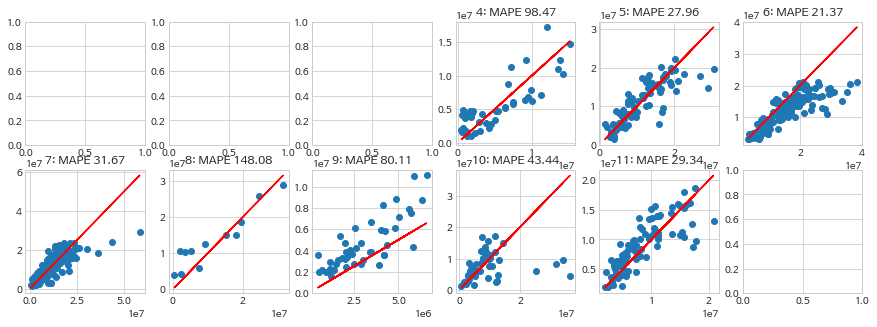

In [183]:
plot_result(cv_test, cv_predict, cv_scores)

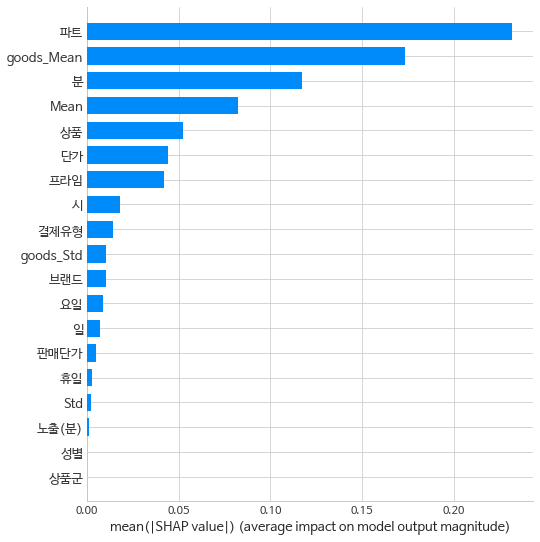

In [184]:
explainer = shap.TreeExplainer(cv_models[6])
shap_values = explainer.shap_values(cv_test_dataset[6])
shap.summary_plot(shap_values, train_x, plot_type="bar",)

In [185]:
data_group['침구'] = data

## 건강기능

In [366]:
data = data_group['건강기능'].copy()

### feature_상품

In [367]:
goods_건강기능 = ['프로바이오틱스','콜라겐','과일즙','건강즙','영양제',
                  '다이어트식품','비타민제','두유','차류','오메가3','홍삼','생식']

data.상품명 = data.상품명.str.replace('유산균', '프로바이오틱스', regex = False)
data.상품명 = data.상품명.str.replace('신바이오틱스', '프로바이오틱스', regex = False)
data.상품명 = data.상품명.str.replace('석류', '과일즙', regex = False)

data.상품명 = data.상품명.str.replace('모나코사놀', '영양제', regex = False)
data.상품명 = data.상품명.str.replace('루테인', '영양제', regex = False)
data.상품명 = data.상품명.str.replace('프리바이오틱스', '영양제', regex = False)
data.상품명 = data.상품명.str.replace('초록입홍합 환', '영양제', regex = False)
data.상품명 = data.상품명.str.replace('전립쎈', '영양제', regex = False)

data.상품명 = data.상품명.str.replace('티톡', '다이어트식품', regex = False)
data.상품명 = data.상품명.str.replace('다이어트 구미', '다이어트식품', regex = False)

data.상품명 = data.상품명.str.replace('레모나', '비타민제', regex = False)
data.상품명 = data.상품명.str.replace('레드비트즙', '건강즙', regex = False)
data.상품명 = data.상품명.str.replace('레드비트 착즙', '건강즙', regex = False)
data.상품명 = data.상품명.str.replace('클렌즈', '건강즙', regex = False)
data.상품명 = data.상품명.str.replace('철갑상어', '건강즙', regex = False)
data.상품명 = data.상품명.str.replace('양배추진액', '건강즙', regex = False)

data.상품명 = data.상품명.str.replace('히비스커스', '차류', regex = False)
data.상품명 = data.상품명.str.replace('허브차', '차류', regex = False)
data.상품명 = data.상품명.str.replace('해죽순', '차류', regex = False)


data = separate(data, goods_건강기능)
data['상품'] = data.상품명.map(lambda x: goods_name(x, goods_건강기능)) 
#data['상품'] = data.상품.map(lambda x: '가구세트' if type(x) != str else x)

### feature_단가

In [368]:
sametime_count = data.groupby(['월','일','시','분','브랜드','결제유형']).count()['상품명'].to_frame()
sametime_df_ = data.groupby(['월','일','시','분','브랜드','결제유형','상품명']).mean()['판매단가'].to_frame()

sametime_df = sametime_df_[sametime_count.상품명 > 1]

Boolean Series key will be reindexed to match DataFrame index.


In [369]:
def cheap_expensive(x):
    try: 
        idx_list = sametime_df.loc[(x.월, x.일, x.시, x.분, x.브랜드, x.상품, x.결제유형)].values.reshape(-1).tolist()
        idx_list.sort()
        idx = idx_list.index(x.판매단가)/(len(idx_list)-1)
        if idx == 0:
            return '하'
        if idx == 1:
            return '상'
        else:
            return '중'
    except KeyError:
        return '해당없음'

data['단가'] = data.apply(lambda x: cheap_expensive(x), axis=1)

### feature_Statistics

In [370]:
mean_df = data.groupby(['요일','시']).mean()['취급액_로그'].to_frame()
std_df = data.groupby(['요일','시']).std()['취급액_로그'].to_frame()

data = data.apply(lambda x: statistics(x), axis =1)

goods_mean_df = data.groupby(['요일','시','결제유형','상품']).mean()['취급액_로그'].to_frame()
goods_std_df = data.groupby(['요일','시','결제유형','상품']).std()['취급액_로그'].to_frame()

def goods_statistics(x):
    goods_mean = goods_mean_df.loc[(x.요일, x.시, x.결제유형, x.상품)].values[0]
    goods_std = goods_std_df.loc[(x.요일, x.시, x.결제유형, x.상품)].values[0]
    x['goods_Mean'] = goods_mean
    x['goods_Std'] = goods_std

    return x

data = data.apply(lambda x:goods_statistics(x), axis =1)

In [371]:
data.to_csv('group_건강기능.csv')

### Train CATBoost

In [191]:
month = list(set(data.월))

raw_x = data.drop(columns=['취급액_로그','상품명'])
raw_y = data[['취급액_로그','월']]

cv_test = {}
cv_predict = {}
cv_scores = {}
cv_models = {}
cv_test_dataset = {}

for m in month:

    # try:

    test_x = raw_x[raw_x.월 == m].drop(columns = ['월'])
    test_y = raw_y[raw_y.월 == m].취급액_로그
    train_x = raw_x.drop(index = test_x.index, columns = ['월'])
    train_y = raw_y.drop(index = test_y.index).취급액_로그

    # test_x = mmscaler.fit_transform(test_x)
    # train_x = mmscaler.fit_transform(train_x)

    train_y = train_y.to_numpy().reshape(-1)
    test_y = test_y.to_numpy().reshape(-1)

    cat_features_train = np.where((train_x.dtypes != np.float)&(train_x.dtypes != np.int))[0]
    cat_features_test = np.where((test_x.dtypes != np.float)&(test_x.dtypes != np.int))[0]
    
    train_dataset = Pool(train_x, label = train_y, cat_features=cat_features_train)
    test_dataset = Pool(test_x, label = test_y, cat_features=cat_features_test)
    CBR = model.fit(train_dataset,  
                    eval_set = test_dataset,
                    use_best_model = True,      
                    verbose_eval = 500,
                    plot = False)
    predict_test = model.predict(test_x)

    test_y = np.exp(test_y)
    predict_test = np.exp(predict_test)

    cv_test.update({m:test_y})
    cv_predict.update({m: predict_test})

    mape = mean_absolute_percentage_error(test_y, predict_test)
    print(f'{m}월 MAPE:', mape)

    cv_scores.update({m:mape})
    cv_models.update({m:model})
    cv_test_dataset.update({m:test_dataset})

    print(' ')

0:	learn: 0.0342793	test: 0.0303334	best: 0.0303334 (0)	total: 6.01ms	remaining: 12s
500:	learn: 0.0037686	test: 0.0104410	best: 0.0098750 (176)	total: 3.13s	remaining: 9.38s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.009875006319
bestIteration = 176

Shrink model to first 177 iterations.
1월 MAPE: 16.791707695824933
 
0:	learn: 0.0340498	test: 0.0350171	best: 0.0350171 (0)	total: 6.77ms	remaining: 13.5s
500:	learn: 0.0036875	test: 0.0130124	best: 0.0121923 (244)	total: 3.15s	remaining: 9.43s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.01219228096
bestIteration = 244

Shrink model to first 245 iterations.
2월 MAPE: 22.350861883213476
 
0:	learn: 0.0332566	test: 0.0445395	best: 0.0445395 (0)	total: 6.31ms	remaining: 12.6s
500:	learn: 0.0035406	test: 0.0213582	best: 0.0205947 (73)	total: 3.13s	remaining: 9.38s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.02059471152
bestIteration = 73

Shrink model to first 74 itera

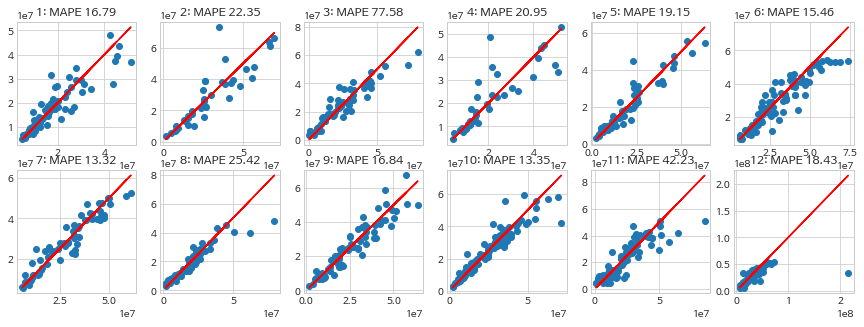

In [192]:
plot_result(cv_test, cv_predict, cv_scores)

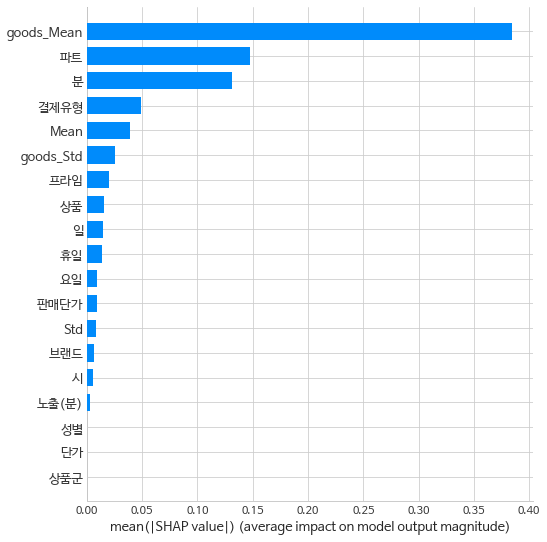

In [193]:
explainer = shap.TreeExplainer(cv_models[6])
shap_values = explainer.shap_values(cv_test_dataset[6])
shap.summary_plot(shap_values, train_x, plot_type="bar",)

In [194]:
data_group['건강기능'] = data

## 생활용품

In [372]:
data = data_group['생활용품'].copy()

### feature_상품

In [374]:
## 생활용품의 경우 상품이 매우 다양하여 자주 나타난 상품만 전처리를 하고자 함

brand_list = ['세렌셉템버','선일금고']
def brand(x):
    x.상품명 = x.상품명.replace('가)','')
    for s in x.상품명.split():
        if s in brand_list:
            return s

data.브랜드 = data.apply(lambda x: brand(x) if type(x.브랜드) != str else x.브랜드, axis=1)

In [375]:
#data.상품명 = data.상품명.replace('[+]\w+','')
data.상품명 = data.상품명.replace('온수 카페트매트','온수카페트매트')

mat_type = ['온열매트','온수매트','카페트매트','온수카페트매트']
def mat(x):
    word = []
    for s in x.상품명.split():
        if s in mat_type:
            if '퀸' in x.상품명:
                return x.브랜드 + s + '퀸사이즈'
            if '싱글' in x.상품명:
                return x.브랜드 + s + '싱글사이즈'
            if '킹' in x.상품명:
                return x.브랜드 + s + '킹사이즈'
            else:
                return x.브랜드 + s
            word.append(s)
    if len(word) == 0:
        return x.브랜드

data['상품'] = data.apply(lambda x: mat(x), axis=1)

### feature_단가

In [376]:
sametime_count = data.groupby(['월','일','시','분','브랜드','상품','결제유형']).count()['상품명'].to_frame()
sametime_df_ = data.groupby(['월','일','시','분','브랜드','상품','결제유형','상품명']).mean()['판매단가'].to_frame()

sametime_df = sametime_df_[sametime_count.상품명 > 1]
sametime_df

Boolean Series key will be reindexed to match DataFrame index.


판매단가
월  일  시  분  브랜드 상품          결제유형 상품명                       
2  22 7  00 벨라홈 벨라홈         해당없음 벨라홈 논슬립 옷걸이 세트       29800
                                 벨라홈 논슬립 옷걸이 세트 1+1   49800
         20 벨라홈 벨라홈         해당없음 벨라홈 논슬립 옷걸이 세트       29800
                                 벨라홈 논슬립 옷걸이 세트 1+1   49800
         40 벨라홈 벨라홈         해당없음 벨라홈 논슬립 옷걸이 세트       29800
...                                                     ...
12 9  12 00 일월  일월온수매트싱글사이즈 해당없음 (싱글+싱글)일월 품안애 온수매트  198000
                                 (싱글사이즈)일월 품안애 온수매트  118000
                일월온수매트퀸사이즈  해당없음 (퀸+싱글)일월 품안애 온수매트   218000
                                 (퀸+퀸)일월 품안애 온수매트    248000
                                 (퀸사이즈)일월 품안애 온수매트   148000

[1351 rows x 1 columns]

In [377]:
def cheap_expensive(x):
    try: 
        idx_list = sametime_df.loc[(x.월, x.일, x.시, x.분, x.브랜드, x.상품, x.결제유형)].values.reshape(-1).tolist()
        idx_list.sort()
        idx = idx_list.index(x.판매단가)/(len(idx_list)-1)
        if idx == 0:
            return '하'
        if idx == 1:
            return '상'
        else:
            return '중'
    except KeyError:
        return '해당없음'

data['단가'] = data.apply(lambda x: cheap_expensive(x), axis=1)

In [378]:
## 오버피팅 위험으로 상품별 통계치 변수는 추가하지 않음

mean_df = data.groupby(['요일','시']).mean()['취급액_로그'].to_frame()
std_df = data.groupby(['요일','시']).std()['취급액_로그'].to_frame()

def statistics(x):
    mean = mean_df.loc[(x.요일, x.시)].values[0]
    std = std_df.loc[(x.요일, x.시)].values[0]
    x['Mean'] = mean
    x['Std'] = std

    return x

data = data.apply(lambda x: statistics(x), axis =1)

In [380]:
data.to_csv('group_생활용품.csv')

### Train CATBoost

In [201]:
month = list(set(data.월))

raw_x = data.drop(columns=['취급액_로그','상품명'])
raw_y = data[['취급액_로그','월']]

cv_test = {}
cv_predict = {}
cv_scores = {}
cv_models = {}
cv_test_dataset = {}

for m in month:

    # try:

    test_x = raw_x[raw_x.월 == m].drop(columns = ['월'])
    test_y = raw_y[raw_y.월 == m].취급액_로그
    train_x = raw_x.drop(index = test_x.index, columns = ['월'])
    train_y = raw_y.drop(index = test_y.index).취급액_로그

    # test_x = mmscaler.fit_transform(test_x)
    # train_x = mmscaler.fit_transform(train_x)

    train_y = train_y.to_numpy().reshape(-1)
    test_y = test_y.to_numpy().reshape(-1)

    cat_features_train = np.where((train_x.dtypes != np.float)&(train_x.dtypes != np.int))[0]
    cat_features_test = np.where((test_x.dtypes != np.float)&(test_x.dtypes != np.int))[0]
    
    train_dataset = Pool(train_x, label = train_y, cat_features=cat_features_train)
    test_dataset = Pool(test_x, label = test_y, cat_features=cat_features_test)
    CBR = model.fit(train_dataset,  
                    eval_set = test_dataset,
                    use_best_model = True,      
                    verbose_eval = 500,
                    plot = False)
    predict_test = model.predict(test_x)

    test_y = np.exp(test_y)
    predict_test = np.exp(predict_test)

    cv_test.update({m:test_y})
    cv_predict.update({m: predict_test})

    mape = mean_absolute_percentage_error(test_y, predict_test)
    print(f'{m}월 MAPE:', mape)

    cv_scores.update({m:mape})
    cv_models.update({m:model})
    cv_test_dataset.update({m:test_dataset})

    print(' ')

0:	learn: 0.0518430	test: 0.0531625	best: 0.0531625 (0)	total: 12.5ms	remaining: 25s
500:	learn: 0.0134353	test: 0.0201912	best: 0.0191112 (75)	total: 5.1s	remaining: 15.3s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.01911124187
bestIteration = 75

Shrink model to first 76 iterations.
1월 MAPE: 31.791998347082213
 
0:	learn: 0.0524887	test: 0.0577071	best: 0.0577071 (0)	total: 10.7ms	remaining: 21.5s
500:	learn: 0.0136478	test: 0.0252623	best: 0.0251388 (122)	total: 5.09s	remaining: 15.2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.0251387821
bestIteration = 122

Shrink model to first 123 iterations.
2월 MAPE: 73.17621173843987
 
0:	learn: 0.0518711	test: 0.0517641	best: 0.0517641 (0)	total: 9.87ms	remaining: 19.7s
500:	learn: 0.0138705	test: 0.0218200	best: 0.0214502 (370)	total: 4.94s	remaining: 14.8s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.02145018149
bestIteration = 370

Shrink model to first 371 iteration

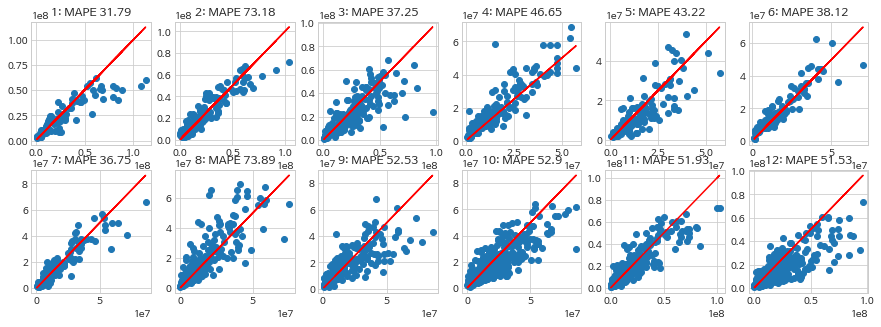

In [202]:
plot_result(cv_test, cv_predict, cv_scores)

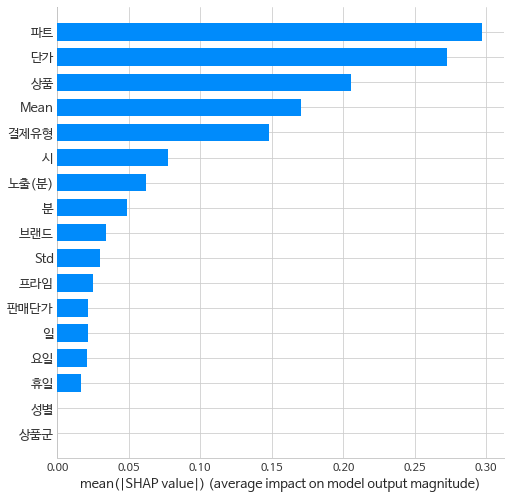

In [203]:
explainer = shap.TreeExplainer(cv_models[6])
shap_values = explainer.shap_values(cv_test_dataset[6])
shap.summary_plot(shap_values, train_x, plot_type="bar",)

In [204]:
data_group['생활용품'] = data